### Pre configurazione se si usa colab

In [ ]:
%%bash
pip install torch torchvision torchaudio
python -c "import torch; print(torch.version.cuda)"
TORCH=1.10.0
CUDA=cu111
pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
pip install torch-geometric

#scaricamento dataset
wget -P ./dataset-raw https://raw.githubusercontent.com/naddi96/progetto-ML/master/dataset-raw/cora.cites
wget -P ./dataset-raw https://raw.githubusercontent.com/naddi96/progetto-ML/master/dataset-raw/cora.content

# Sperimentazione di tecchine di apprendimento sul dataset Cora 

## informazioni sul dataset
Il dataset Cora è costituito da 2708 pubblicazioni scientifiche classificate in una delle sette classi. La rete di citazioni è composta da 5278 link. Ogni pubblicazione nel set di dati è descritta da un vettore di parole con valore 0/1 che indica l'assenza/presenza della parola corrispondente dal dizionario. Il dizionario è composto da 1433 parole uniche.


## importazionde delle librerie

In [5]:
from sklearn.manifold import TSNE
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torch_geometric.data import Data
import numpy as np
import torch
import random
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from sklearn.preprocessing import OneHotEncoder

import sklearn
from sklearn import metrics
from sklearn.model_selection import KFold


import networkx as nx
from networkx.algorithms import community 
from matplotlib import pylab

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Caricamento del dataset in memoria e split in train/test

In [2]:
class MyDatasetLoader(InMemoryDataset):
    
    def __init__(self, root, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        #self.num_node_features=1433
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['cora.cites', 'cora.content']

    @property
    def processed_file_names(self):
        return ['cites.pt',"content.pt"]


    def process(self): 
        feat_data, labels, edge_index, word_count, labels_count,label_map = self.load_cora_raw()
        edge_index= torch.tensor(edge_index)
        labels=  torch.tensor(labels, dtype=torch.long)
        num_nodes=2708
        feat_data=torch.tensor(feat_data,dtype=torch.float32)


        data = Data(x=feat_data,
                    edge_index=edge_index,
                    y=labels,
                    word_count=word_count,
                    labels_count=labels_count,
                    label_map=label_map)
        data.train_mask= torch.zeros([2708], dtype=torch.bool) 
        data.train_mask.fill_(True)
        data.test_mask= torch.zeros([2708], dtype=torch.bool) 
        data.test_mask.fill_(False)
        data.val_mask= torch.zeros([2708], dtype=torch.bool) 
        data.val_mask.fill_(False)
        random.seed(453)
        sampled_test = random.sample(range(num_nodes), int(num_nodes*0.20))
        data.train_mask[sampled_test]=False
        sampled_val=[]
        #data.x[sampled_test]= torch.zeros([1433], dtype=torch.float32)
        """for x in range(0,int(num_nodes*0.1)):
            num=sampled_test.pop()
            sampled_val.append(num)
        
        data.val_mask[sampled_val]=True """
        data.test_mask[sampled_test]=True
        

        data = data if self.pre_transform is None else self.pre_transform(data)
        
        torch.save(self.collate([data]), self.processed_paths[0])

    @staticmethod
    def load_cora_raw():
        word_count={}
        for x in range(0,1433):
            word_count[x]=0
        labels_count={}
        numero_nodi=2708
        numero_feature=1433
        feat_data = np.zeros((numero_nodi, numero_feature))
        labels = np.empty((numero_nodi), dtype=np.int32)
        node_map = {}
        label_map = {}
        with open("./dataset-raw/cora.content") as fp:
            for i,line in enumerate(fp):
                info = line.strip().split()
            # print(info[1:-1])
                data =[]
                for x in info[1:-1]:
                    data.append(float(x))
                node_map[info[0]]=i
                feat_data[i,:] = data
                
                if not info[-1] in label_map:
                    label_map[info[-1]] = len(label_map)
                    labels_count[info[-1]]=1    

                labels_count[info[-1]]=labels_count[info[-1]]+1
                labels[i] = label_map[info[-1]]

                

                for i,val in enumerate(data):
                    word_count[i]=word_count[i]+val
        
        #from collections import defaultdict
        #adj_lists = defaultdict(set)
        edge_list1=[]
        edge_list2=[]
        with open("./dataset-raw/cora.cites") as fp:
            for i,line in enumerate(fp):
                info = line.strip().split()
                paper1 = node_map[info[0]]
                paper2 = node_map[info[1]]

                edge_list1.append(paper1)
                edge_list1.append(paper2)
                edge_list2.append(paper2)
                edge_list2.append(paper1)


        return feat_data, labels , [edge_list1,edge_list2],word_count,labels_count,label_map



dataset=MyDatasetLoader(root='./cora')
#reduce_dim_pca(dataset,100)
train_x= dataset[0].x[dataset[0].train_mask]
train_y= dataset[0].y[dataset[0].train_mask]
test_x = dataset[0].x[dataset[0].test_mask]
test_y = dataset[0].y[dataset[0].test_mask]

print(sum(train_x[500]))


from sklearn.base import BaseEstimator, TransformerMixin

class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return input_array
    
    def transform(self, input_array, y=None):
        return input_array



prova=IdentityTransformer()

x=prova.fit(train_x)
print(x)
print(sum(x[500]))




Processing...


tensor(24.)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor(24.)


Done!


# funzioni utili

In [3]:


dict_valutazioni={}


def GridSearch_table_plot(grid_clf, param_list=[],
                          num_results=40,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    '''Display grid search results

    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    #if display_all_params:
     #   import pprint
      #  pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    #best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    table=pd.DataFrame(cv_results)
    del table['split0_test_score']
    del table['split1_test_score']
    del table['split2_test_score']
    del table['split3_test_score']
    del table['split4_test_score']
    del table['split0_train_score']
    del table['split1_train_score']
    del table['split2_train_score']
    del table['split3_train_score']
    del table['split4_train_score']
    del table['mean_fit_time']
    del table['std_fit_time']
    del table['mean_score_time']	
    del table['std_score_time']
    del table['param_reduce_dim']
    del table['params']
    display(table \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='rank_test_score')
    print(scores_df.keys())
    for param_name in param_list:
        scores_df = scores_df.sort_values(by='param_' + param_name)
        best_param = best_row['param_' + param_name]
        
        if negative:
            means = -scores_df['mean_test_score']
        else:
            means = scores_df['mean_test_score']
        stds = scores_df['std_test_score']
        params = scores_df['param_' + param_name]
        params.fillna(1400, inplace=True)
        #params = [str(i) for i in params]
        # plot
        if graph:
            plt.figure(figsize=(8, 8))
            plt.errorbar(params, means)

            plt.axhline(y=best_mean + best_stdev, color='red')
            plt.axhline(y=best_mean - best_stdev, color='red')
            plt.plot(best_param, best_mean, 'or')

            plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
            plt.xlabel(param_name)
            plt.ylabel('Score')
    plt.show()







def reduce_dim_pca(dataset,reduce_dim_to):
    pca = PCA(n_components=reduce_dim_to)
    x= pca.fit_transform(dataset[0].x)
   
    dataset.data.x =torch.tensor(x,dtype=torch.float32)
    return 



def valutate_test(Y,Y_pred):
    acc=metrics.accuracy_score(Y, Y_pred)
    f=metrics.f1_score(Y, Y_pred,average='macro')
    confmatr=metrics.confusion_matrix(Y, Y_pred)
    return {'Accuracy':acc,"f1":f,"Confusion Matrix":confmatr}


def valutate_model_with_kfold(model,X,Y,n_splits):
    kfold = KFold(n_splits=n_splits, shuffle=True)
    train_x=X
    train_y=Y
    accuracy_list=[]
    f1_list=[]
    for train, test in kfold.split(train_x, train_y):
        
        model =model.fit(train_x[train],train_y[train])
        y_pred = model.predict(train_x[test])
        accuracy=metrics.accuracy_score(train_y[test], y_pred)
        f1=metrics.f1_score(train_y[test], y_pred,average='macro')
        accuracy_list.append(accuracy)
        f1_list.append(f1)

    accuracy=sum(accuracy_list)/len(accuracy_list)
    f1=sum(f1_list)/len(f1_list)
    return {"accuracy":accuracy,"f1":f1}

def compute_TSNE(emb):
    xs, ys = zip(*TSNE(init='pca',random_state=33).fit_transform(emb.detach().numpy()))
    return torch.Tensor(xs), torch.Tensor(ys)

def plot_embeddings(xs,ys,labels):
    color_list = ["red", "orange", "green", "blue", "purple", "brown","black","gray","yellow"]
    colors = []
    colors += [color_list[y] for y in labels]
    plt.figure(figsize = (10, 10))
    plt.scatter(xs, ys, color=colors)

def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    plt.savefig(file_name,bbox_inches="tight")
    #pylab.close()
    del fig


def transform_to_one_hot(x):
    ohe = OneHotEncoder()
    return ohe.fit_transform(x.reshape(-1, 1)).toarray()

def argmax_one_hot(y_pred):
    ohe = OneHotEncoder()
    return ohe.fit_transform(np.argmax(y_pred,axis=1).reshape(-1, 1)).toarray()


# Statistiche sul dataset 

In [ ]:
dataset=MyDatasetLoader(root='./cora')
train_y= dataset[0].y[dataset[0].train_mask]
test_y = dataset[0].y[dataset[0].test_mask]
train_x=dataset[0].x[dataset[0].train_mask]
test_x=dataset[0].x[dataset[0].test_mask]
word_count=dataset[0].word_count

Processing...
Done!


## Heat map delle feature rispetto alle classi
    Asse y -> features
    Asse x -> classi

    0 -> Neural_Networks \
    1 -> Rule_Learning \
    2 -> Reinforcement_Learning \ 
    3 -> Probabilistic_Methods \
    4 -> Theory \
    5 -> Genetic_Algorithms \
    6 -> Case_Based 

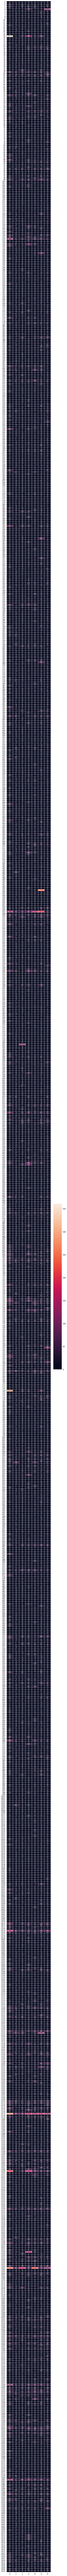

In [ ]:
matrix=np.zeros((len(dataset[0].x[0]),7))
for element,label in zip(dataset[0].x,dataset[0].y):
    for feature,index in zip(element,range(0,len(element))):
        matrix[index][label]=matrix[index][label]+feature

matrice=matrix
#matrix[matrix==0.0]=np.nan
plt.figure(figsize = (6,0.2*len(matrice)))
sns.heatmap(matrice, annot=True, linewidths=.5)
plt.show()

## Grafico a barre del della frequenza delle feature rispetto ai documenti

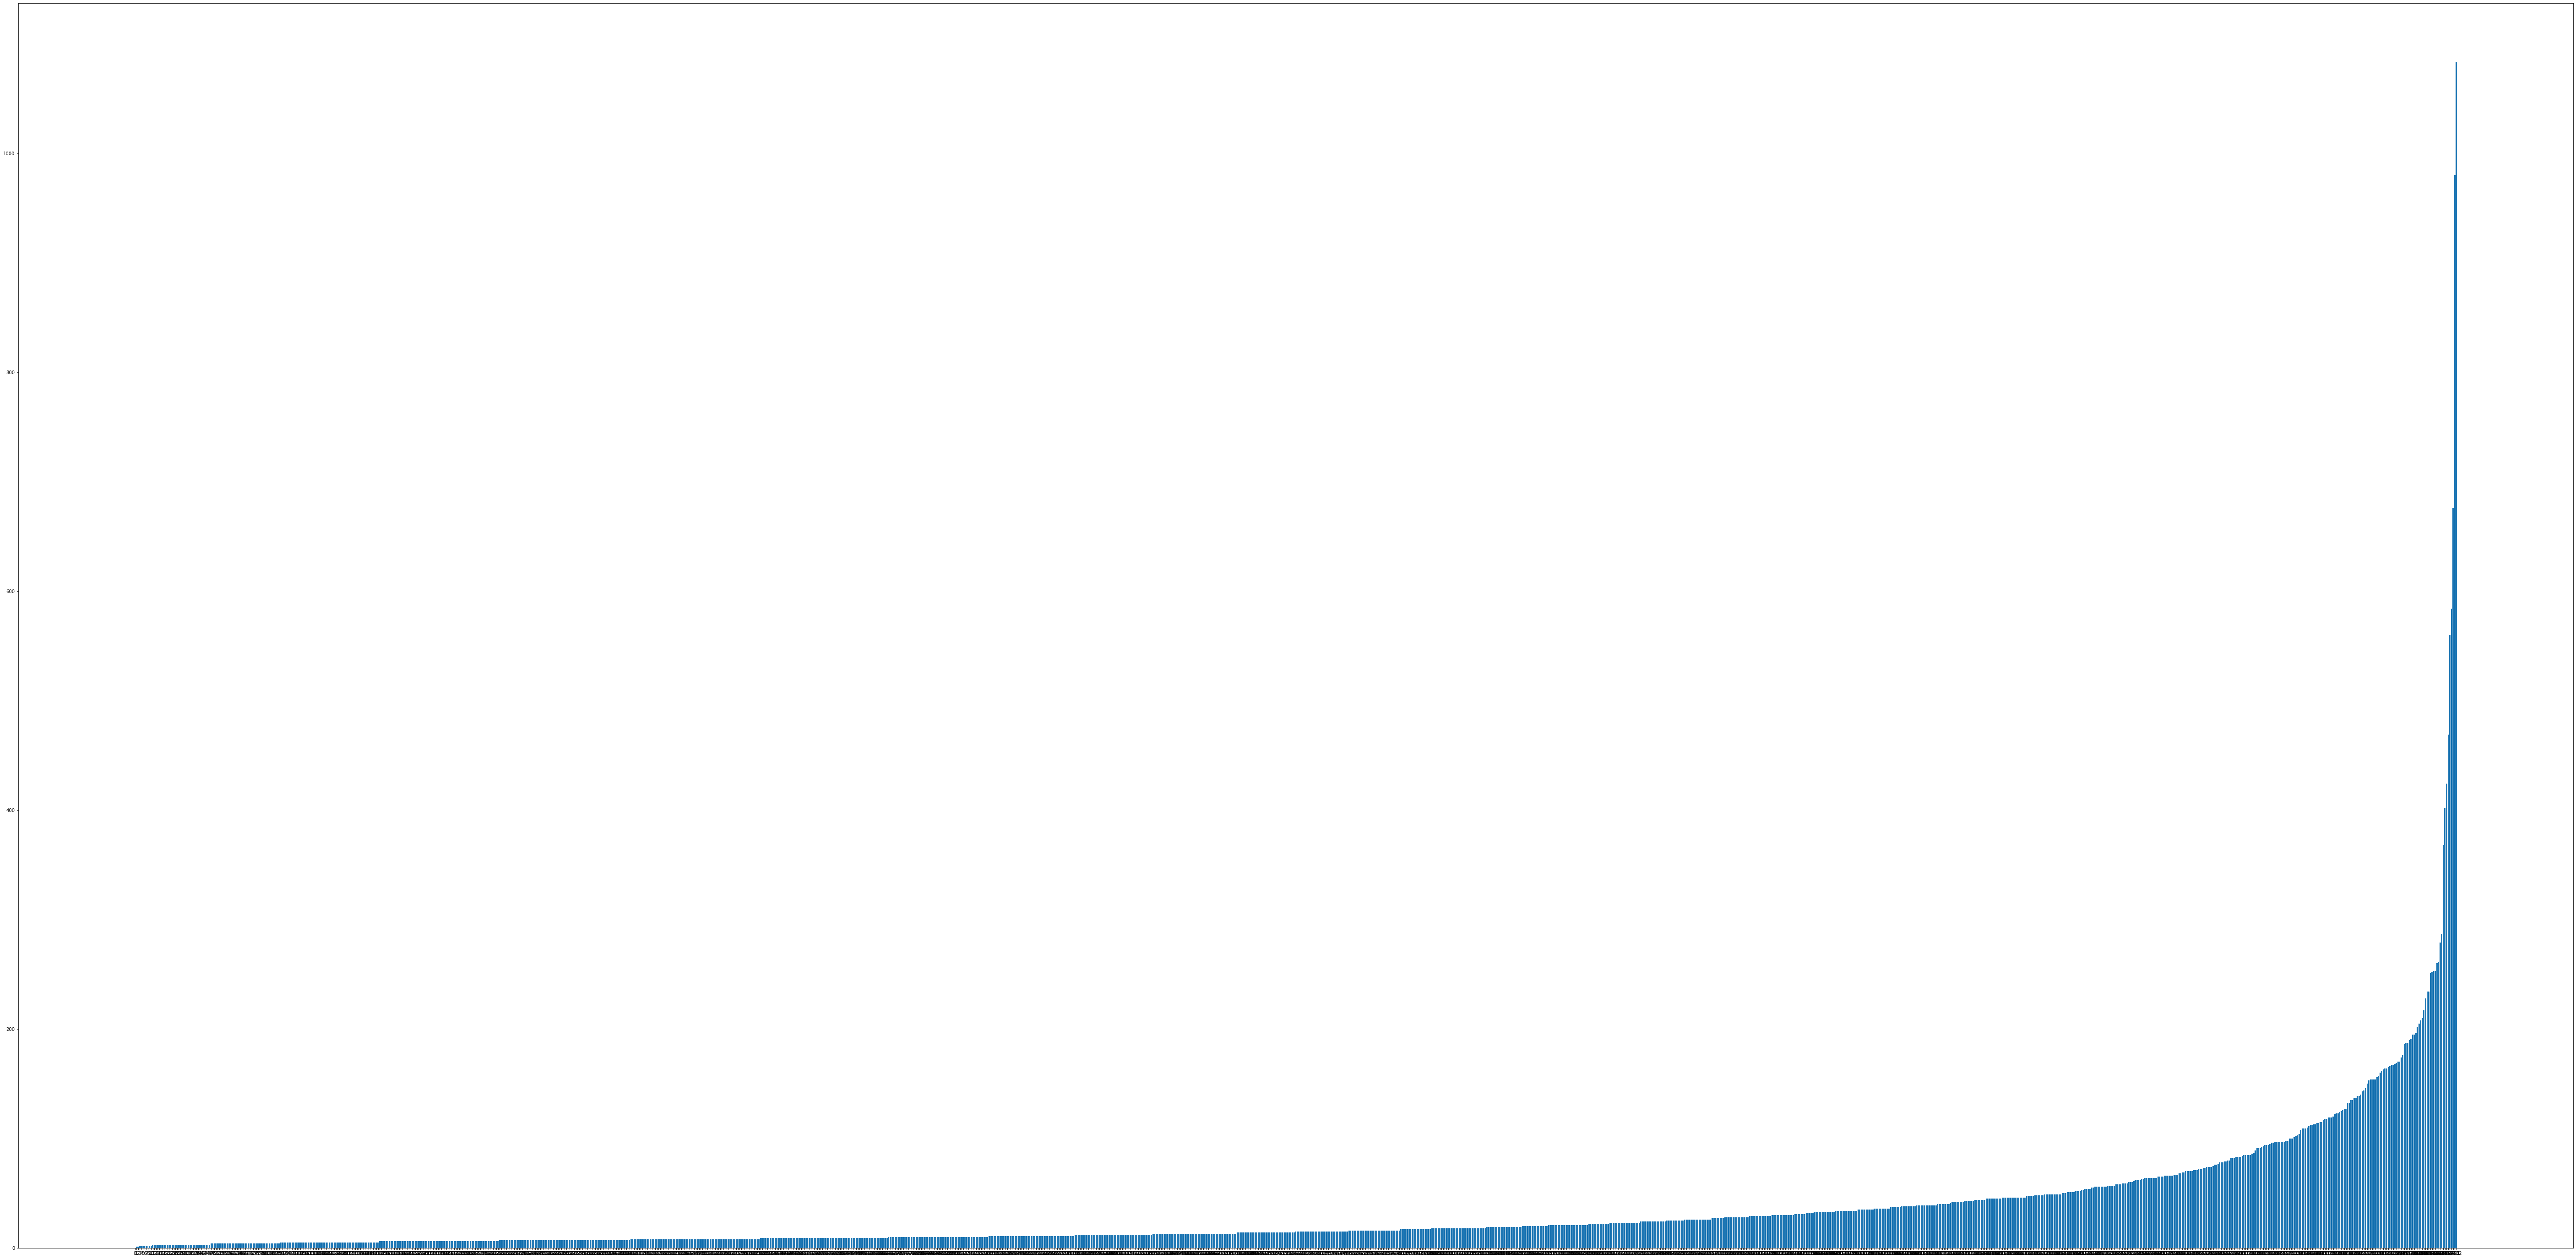

occorrenza massima:  1083.0
occorrenza minima:   0.0
occorenza media:     34.34473133286811


In [ ]:

plt.figure(figsize = (100, 50))
plt.bar(range(len(word_count)), sorted(list(word_count.values())), align='center')
plt.xticks(range(len(word_count)), list(word_count.keys()))
plt.show()
def avg(lst):
    return sum(lst) / len(lst)
print("occorrenza massima: ",max(list(word_count.values())))
print("occorrenza minima:  ",min(list(word_count.values())))
print("occorenza media:    ",avg(list(word_count.values())))

## Numero di documenti per etichetta

### Numero di documenti per etichetta su tutto il dataset

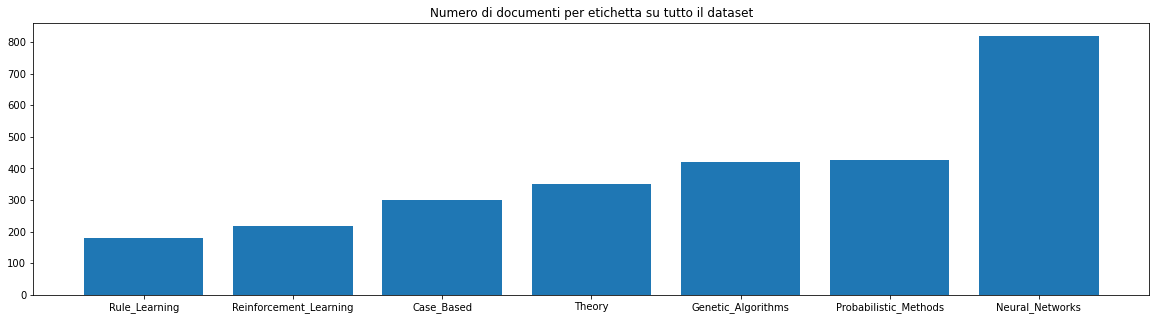

In [ ]:
labels_count=dataset[0].labels_count
Z = [x for _,x in sorted(zip(list(labels_count.values()),list(labels_count.keys())))]
plt.figure(figsize = (20, 5))
plt.bar(range(len(labels_count)), sorted(list(labels_count.values())), align='center')
plt.xticks(range(len(labels_count)),Z)
plt.title('Numero di documenti per etichetta su tutto il dataset')
plt.show()

### Numero di documenti per etichetta sul training set

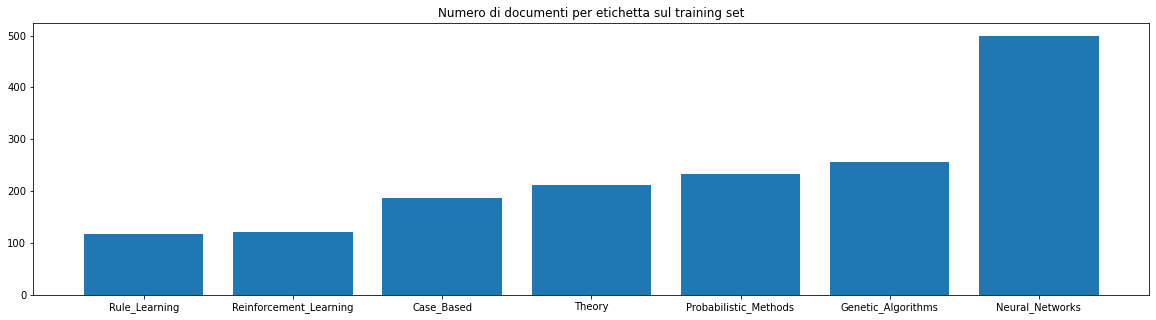

In [ ]:
label_map=inv_map = {dataset.data.label_map[k] : k for k in dataset.data.label_map}
labels_count=dataset[0].labels_count
for x in labels_count.keys():
    labels_count[x]=0
for label in train_y:
    labels_count[label_map[int(label)]]+=1
Z = [x for _,x in sorted(zip(list(labels_count.values()),list(labels_count.keys())))]
plt.figure(figsize = (20, 5))
plt.bar(range(len(labels_count)), sorted(list(labels_count.values())), align='center')
plt.xticks(range(len(labels_count)),Z)
plt.title('Numero di documenti per etichetta sul training set')
plt.show()

### Numero di documenti per etichetta sul test set

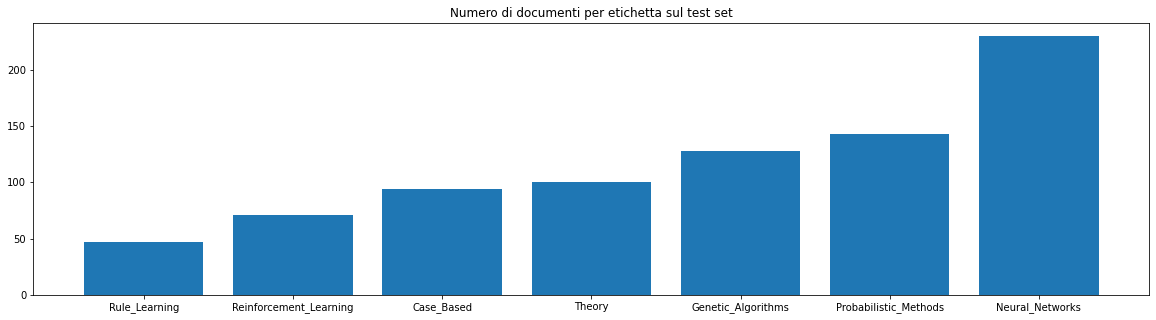

In [ ]:
labels_count=dataset[0].labels_count
for x in labels_count.keys():
    labels_count[x]=0
for label in test_y:
    labels_count[label_map[int(label)]]+=1
Z = [x for _,x in sorted(zip(list(labels_count.values()),list(labels_count.keys())))]
plt.figure(figsize = (20, 5))
plt.bar(range(len(labels_count)), sorted(list(labels_count.values())), align='center')
plt.xticks(range(len(labels_count)),Z)
plt.title('Numero di documenti per etichetta sul test set')
plt.show()

## Plot dei punti delle feature del trainig set con colorazione rispetto alla label (TSNE)
Con tecnica di riduzione t-distributed stochastic neighbor embedding (TSNE)

Colore associato alla label: 0 -> Neural_Networks -> red 
Colore associato alla label: 1 -> Rule_Learning -> orange 
Colore associato alla label: 2 -> Reinforcement_Learning -> green 
Colore associato alla label: 3 -> Probabilistic_Methods -> blue 
Colore associato alla label: 4 -> Theory -> purple 
Colore associato alla label: 5 -> Genetic_Algorithms -> brown 
Colore associato alla label: 6 -> Case_Based -> fuchsia 


C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


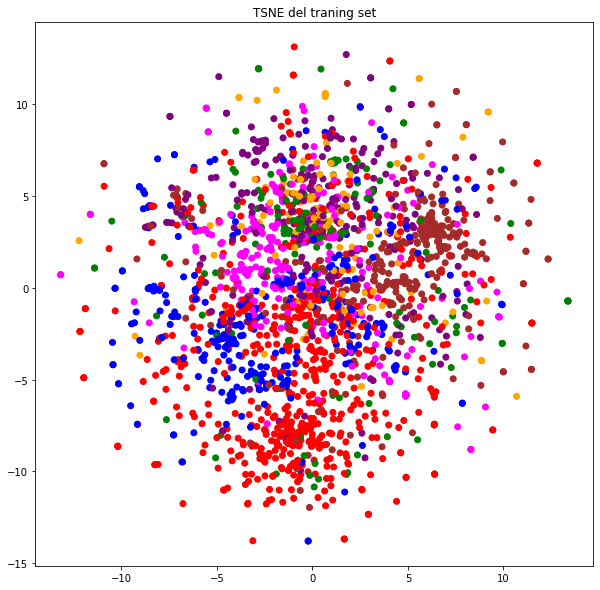

In [ ]:
color_list = ["red", "orange", "green", "blue", "purple", "brown","fuchsia"]
colors_train = []
colors_train +=  [color_list[y] for y in dataset[0].y[dataset[0].train_mask]]
for x in label_map.keys():
    print(f"Colore associato alla label: {x} -> {label_map[x]} -> {color_list[x]} "   )

xs_tsne, ys_tsne = zip(*TSNE(learning_rate='auto',init='pca').fit_transform(dataset[0].x))
xs_tsne= torch.Tensor(xs_tsne)
ys_tsne= torch.Tensor(ys_tsne)

xs_tsne_train = xs_tsne[dataset[0].train_mask]
ys_tsne_train = ys_tsne[dataset[0].train_mask]
plt.figure(figsize = (10, 10))
plt.title("TSNE del traning set")
plt.scatter(xs_tsne_train, ys_tsne_train, color=colors_train)

## Plot dei punti delle feature del trainig set con colorazione rispetto alla label (PCA)
Con tecnica di riduzione Principal component analysis (PCA)

Colore associato alla label: 0 -> Neural_Networks -> red 
Colore associato alla label: 1 -> Rule_Learning -> orange 
Colore associato alla label: 2 -> Reinforcement_Learning -> green 
Colore associato alla label: 3 -> Probabilistic_Methods -> blue 
Colore associato alla label: 4 -> Theory -> purple 
Colore associato alla label: 5 -> Genetic_Algorithms -> brown 
Colore associato alla label: 6 -> Case_Based -> fuchsia 


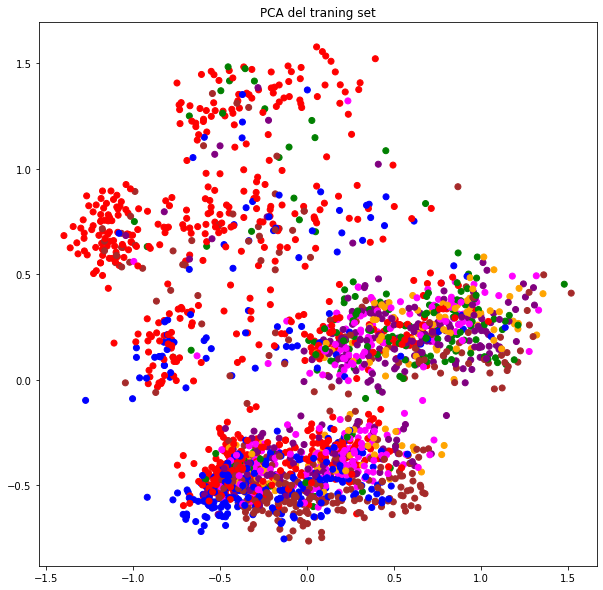

In [ ]:
for x in label_map.keys():
    print(f"Colore associato alla label: {x} -> {label_map[x]} -> {color_list[x]} "   )

pca = PCA(n_components=2)
principalComponents = pca.fit_transform( dataset[0].x)
xs_pca,ys_pca=zip(*principalComponents)
xs_pca= torch.Tensor(xs_pca)
ys_pca= torch.Tensor(ys_pca)
xs_pca_train = xs_pca[dataset[0].train_mask]
ys_pca_train = ys_pca[dataset[0].train_mask]

plt.figure(figsize = (10, 10))
plt.title("PCA del traning set")
plt.scatter(xs_pca_train, ys_pca_train, color=colors_train)



## Plot dei punti delle feature del test set con colorazione rispetto alla label (TSNE)
Con tecnica di riduzione t-distributed stochastic neighbor embedding (TSNE)

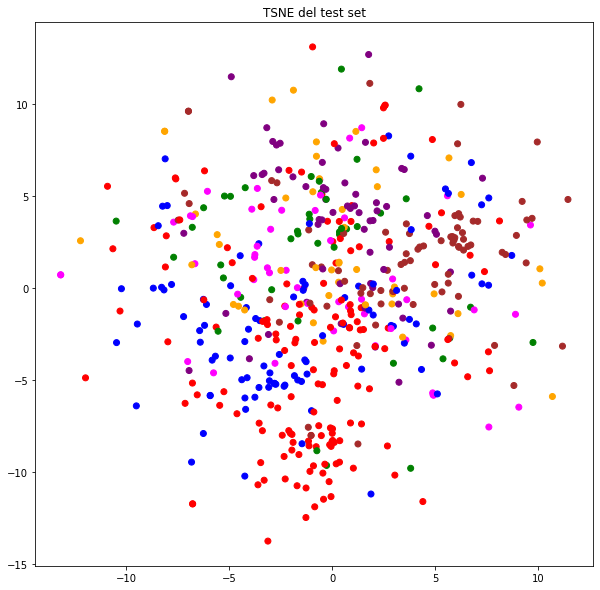

In [ ]:
colors_test=[]
colors_test +=  [color_list[y] for y in test_y]
xs_tsne_test=xs_tsne[dataset[0].test_mask]
ys_tsne_test=ys_tsne[dataset[0].test_mask]
plt.figure(figsize = (10, 10))
plt.title("TSNE del test set")
plt.scatter(xs_tsne_test, ys_tsne_test, color=colors_test)



## Plot dei punti delle feature del test set con colorazione rispetto alla label (PCA)
Con tecnica di riduzione Principal component analysis (PCA)

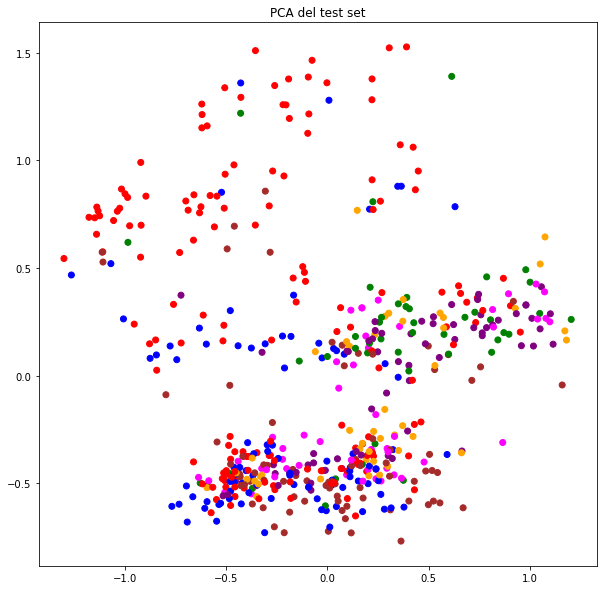

In [ ]:
xs_pca_test=xs_pca[dataset[0].test_mask]
ys_pca_test=ys_pca[dataset[0].test_mask]
plt.figure(figsize = (10, 10))
plt.title("PCA del test set")
plt.scatter(xs_pca_test, ys_pca_test, color=colors_test)

## Alcune statistiche sul grafo

visualizzazzione del grafo interattiva online
https://nocodefunctions.com/html/vosviewer/index.html?json=data/public/vosviewer_de6bf2c77e0fa2c0e672.json

Network density formula: $d= \frac{2m}{n(n-1)}$ 

Triadic closure coefficient :  $T=3\frac{ |triangoli| }{|triadi|}$ \
dove per triade si intende 2 archi che condividono un nodo 

In [18]:


node_atr=[0,1,2,3,4,5,6]

G=torch_geometric.utils.convert.to_networkx(dataset[0],node_attrs=['y'],to_undirected=True)
density = nx.density(G)
print("Network density:", density)
triadic_closure = nx.transitivity(G)
print("Triadic closure:", triadic_closure)
nx.write_gexf(G, 'quaker_network.gexf')
print("Average Degree: ",2*G.number_of_edges() / float(G.number_of_nodes()))
diameter = max([max(j.values()) for (i,j) in nx.shortest_path_length(G)])
print("Diameter: ", diameter)
print(nx.info(G))

Network density: 0.0014399999126942077
Triadic closure: 0.09349725626661058
Average Degree:  3.8980797636632203
Diameter:  19
Graph with 2708 nodes and 5278 edges


![title](https://raw.githubusercontent.com/naddi96/progetto-ML/master/grafo.png)

# Metriche Utilizzate per valutare i modelli

1. Accuracy: $\frac{|esempi \space classificati  \space correttamente|}{|totale \space di \space esempi|}$


2. Macro f1:  $  \frac{1}{|C|}\sum_{i=0}^{|C|} f1score_i$   

$f1score_i= \frac{2 P_i R_i}{P_i+R_i}$ 

dove $P_i$ e $R_i$ sono rispettivamente precision e recall della classe $i$ 

1. Confusion Matrix


# Logistic regression

La regressione logistica è una tecnica di classificazione utilizzata per assegnare osservazioni a un insieme discreto di classi.

A differenza della regressione lineare che restituisce valori numerici continui, la regressione logistica trasforma il proprio output utilizzando la funzione sigmoide o  softmax per restituire un valore di probabilità che può quindi essere mappato a due o più classi discrete.


partiamo dal modello di regressione semplice 

$z^{k}=b+ W^t x^{(k)}$

vi applichiamo la softmax 

$y^{(k)}_i=softmax_i(b+W^t x^{(k)})=\frac{e^{z_i}}{\sum_{j=1}^K{e^{z_j}}}$

dove  $y^{(k)}_i$ è la probabilità predetta della k-esima osservazione con di essere della iesima classe

indiachiamo con indichiamo con $\hat{y}=softmax(z_i)$ il vettore delle probabilità predetto, la funzione di costo nel caso multinomiale ha questa forma 

$L= -  \sum_{j=0}^{K}l_j log(\hat{y}_j)$

dove $l$ è il vettore one hot della label target

per minimizzare il costo possiamo usare gradient descent ma in questo caso specifico è stato utizizzato il Broyden–Fletcher–Goldfarb–Shanno (BFGS)
che è più adatto per datatest con tante variabili 




In [ ]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
cros_valutation=valutate_model_with_kfold(model,dataset[0].x,dataset[0].y,n_splits=5)

dict_valutazioni['LogisticRegression']={"test":test_valutation,"kfold":cros_valutation}

print("Logostic Regression")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print( f"kfold avg Accuracy: {cros_valutation['accuracy']}")
print( f"kfold avg Macro f1: {cros_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")


Logostic Regression
Accuracy: 0.7541589648798521
Macro f1: 0.7303697637390734
kfold avg Accuracy: 0.7673592022426694
kfold avg Macro f1: 0.7434116683654179
Confusion Matrix:
 [[134   3   0   5  13   2   2]
 [  8  23   0   2   8   1   4]
 [  8   0  29   1   3   2   1]
 [ 16   1   1  70   1   0   4]
 [  3   1   1   4  51   3   2]
 [  8   0   1   0   2  70   2]
 [  5   1   1   3   8   2  31]]


0.7943282347242815
2.6101572156825372
8.576958985908943
28.18382931264455
92.61187281287937
304.32198871077225
1000.0


In [174]:

pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('logisticregression', LogisticRegression())])

parametri=  [
                {  
                    "reduce_dim": [PCA()],
                    "reduce_dim__n_components":[64,128,256,512,1024],
                    "logisticregression__penalty":['l1', 'l2', 'elasticnet', 'none'],
                    "logisticregression__solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                    "logisticregression__C": [0.1,0.5,1,10,50,100]
                },
                {
                    "reduce_dim": ["passthrough"],
                    "logisticregression__penalty":['l1', 'l2', 'elasticnet', 'none'],
                    "logisticregression__solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                    "logisticregression__C": [0.1,0.5,1,10,50,100]
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'logisticregression__C': 0.5, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear', 'reduce_dim': 'passthrough'}


C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1620 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in f

best parameters: {'logisticregression__C': 0.5, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear', 'reduce_dim': 'passthrough'}
best score:      0.73756 (+/-0.02007)


,param_logisticregression__C,param_logisticregression__penalty,param_logisticregression__solver,param_reduce_dim__n_components,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
627,0.5,l2,liblinear,NaN,0.737564,0.020069,1,0.967998,0.001543
625,0.5,l2,newton-cg,NaN,0.737360,0.020156,2,0.979018,0.001346
626,0.5,l2,lbfgs,NaN,0.737360,0.020156,2,0.979018,0.001346
629,0.5,l2,saga,NaN,0.737360,0.020156,2,0.978937,0.001335
628,0.5,l2,sag,NaN,0.737302,0.020201,5,0.979184,0.001469
139,0.5,l2,liblinear,1024,0.736701,0.017493,6,0.963676,0.002039
138,0.5,l2,liblinear,512,0.736631,0.022465,7,0.938037,0.003711
144,0.5,l2,sag,1024,0.735525,0.018768,8,0.976765,0.001013
149,0.5,l2,saga,1024,0.735251,0.018325,9,0.976968,0.001062
129,0.5,l2,newton-cg,1024,0.735119,0.018559,10,0.977340,0.001110


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_logisticregression__C', 'param_logisticregression__penalty',
       'param_logisticregression__solver', 'param_reduce_dim',
       'param_reduce_dim__n_components', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')


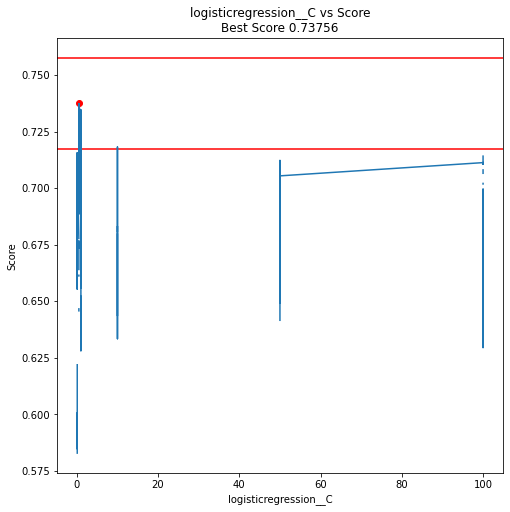

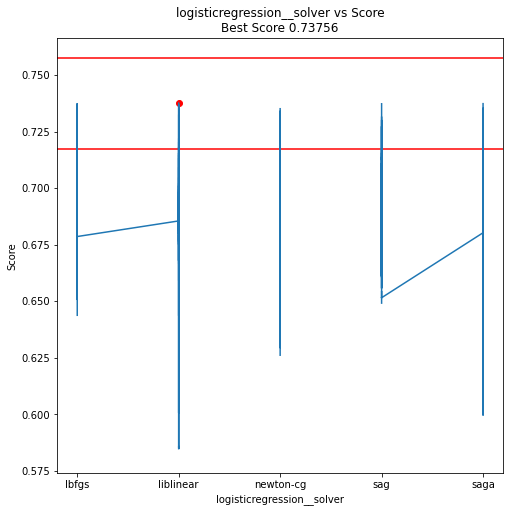

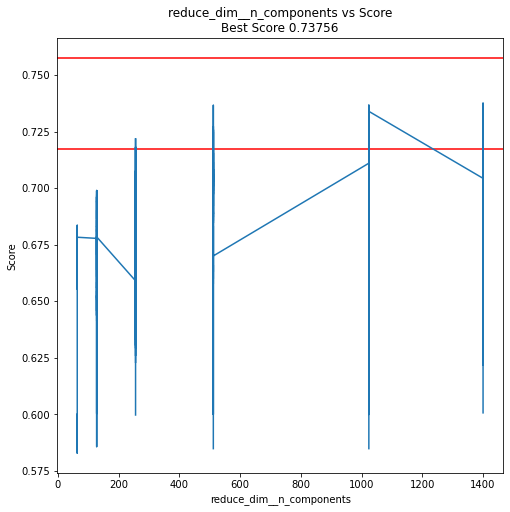

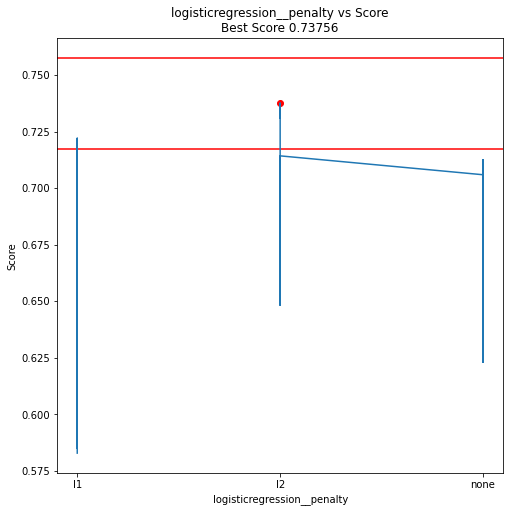

In [175]:


GridSearch_table_plot(grid, param_list=['logisticregression__C','logisticregression__solver',"reduce_dim__n_components","logisticregression__penalty"],negative=False)

In [176]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['LogisticRegression']={"test":test_valutation}
print("Logostic Regression")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")


{'logisticregression__C': 0.5, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear', 'reduce_dim': 'passthrough'}
Logostic Regression
Accuracy: 0.7523105360443623
Macro f1: 0.725920548626872
Confusion Matrix:
 [[135   2   0   7  11   2   2]
 [  8  22   1   2   8   2   3]
 [  7   0  28   2   3   3   1]
 [ 14   1   1  69   3   1   4]
 [  3   1   1   3  52   2   3]
 [  8   0   1   1   2  69   2]
 [  5   1   0   3   8   2  32]]


# Linear Discriminant Analysis
Il modello calcola le probablitià condizionali delle classi dei dati utilizzando la regola di Bayes,

$p(y=k|x) = \frac{P(x|y=k) P(y=k)}{\sum_l P(x|y=l)P(y=l) } $

Il modello effettua fitting rispetto alla densità Gaussiana in ogni classe ed assume che tutte le classi hanno la stessa matrice di covarianza, ossia

$P(x|y=k)$ è modellata con una distribuzione gaussiana:

e quindi avremo la log-posteriori avrà questa forma

$log P(y=k|x) = log P(x|y=k)+ logP(y=k) =$ 
 
$-\frac{1}{2}(x-\mu_k)^t \Sigma^{-1} (x-\mu_k)+log P(y=k) + C_{st}$ 

notiamo che $\Sigma$ è uguale per tutte le classi 




In [6]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('LinearDiscriminantAnalysis',LinearDiscriminantAnalysis(store_covariance=True))])

parametri=  [
                {  
                    "reduce_dim": [PCA()],
                    "reduce_dim__n_components":[64,128,256,512,1024],
                    "LinearDiscriminantAnalysis__solver":['svd', 'lsqr', 'eigen'],
                   
                },
                {
                    "reduce_dim": ["passthrough"],
                    "LinearDiscriminantAnalysis__solver":['svd', 'lsqr', 'eigen'],
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\discriminant_analysis.py", line 599, in fit
    se

tuned hpyerparameters :(best parameters)  {'LinearDiscriminantAnalysis__solver': 'lsqr', 'reduce_dim': PCA(n_components=256), 'reduce_dim__n_components': 256}


best parameters: {'LinearDiscriminantAnalysis__solver': 'lsqr', 'reduce_dim': PCA(n_components=256), 'reduce_dim__n_components': 256}
best score:      0.71908 (+/-0.03389)


,param_LinearDiscriminantAnalysis__solver,param_reduce_dim__n_components,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
7,lsqr,256,0.719080,0.033890,1,0.835402,0.005344
12,eigen,256,0.718784,0.030647,2,0.835613,0.006279
13,eigen,512,0.716007,0.028541,3,0.914415,0.004268
8,lsqr,512,0.715264,0.027496,4,0.913863,0.004983
3,svd,512,0.714435,0.029496,5,0.915818,0.003768
2,svd,256,0.713814,0.035864,6,0.833169,0.004510
1,svd,128,0.703436,0.044444,7,0.777189,0.005271
11,eigen,128,0.702831,0.043330,8,0.780630,0.005395
6,lsqr,128,0.701445,0.042226,9,0.779113,0.005250
0,svd,64,0.678167,0.047658,10,0.732283,0.009734


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_LinearDiscriminantAnalysis__solver', 'param_reduce_dim',
       'param_reduce_dim__n_components', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')


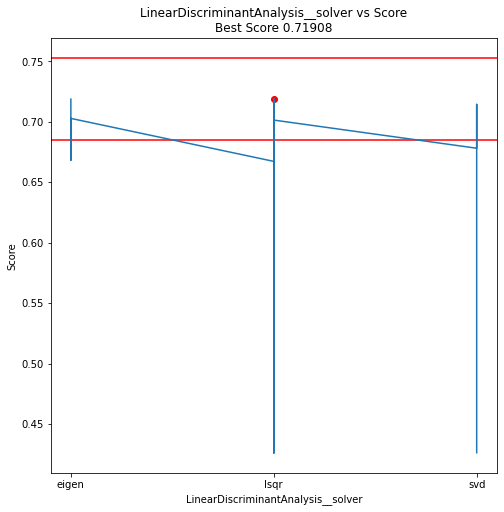

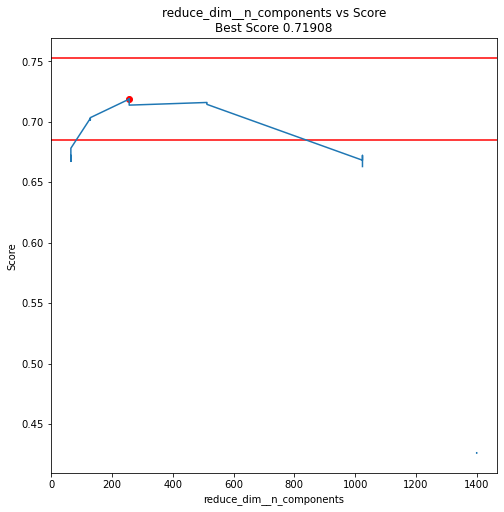

In [7]:
GridSearch_table_plot(grid, param_list=['LinearDiscriminantAnalysis__solver',"reduce_dim__n_components"],negative=False)

In [8]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['LinearDiscriminantAnalysis']={"test":test_valutation}
print("Linear Discriminant Analysis")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")



{'LinearDiscriminantAnalysis__solver': 'lsqr', 'reduce_dim': PCA(n_components=256), 'reduce_dim__n_components': 256}
Linear Discriminant Analysis
Accuracy: 0.7264325323475046
Macro f1: 0.7052906628478784
Confusion Matrix:
 [[135   2   0   4  16   1   1]
 [ 11  24   0   3   5   1   2]
 [  6   0  25   5   6   2   0]
 [ 15   2   0  70   1   0   5]
 [ 10   1   0   1  49   0   4]
 [ 14   0   0   1   2  63   3]
 [  8   1   0   3  12   0  27]]


# Quadratic Discriminant Analysis
La Quadratic Discriminant Analysis non è molto diversa dalla Linear, eccetto per il fatto che assumiamo che la matrice di covarianza possa essere diversa per ogni classe e quindi abbiamo la matrice di covarianza diversa per ogni classe e avremo la seguente log-posteriori

$logP(y=k|x) = -\frac{1}{2} log|\Sigma_k| -\frac{1}{2} (x-\mu_k)^t \Sigma_k^{-1} (x-\mu_k)+ logP(y=k) + C_{st}$

notiamo come nella formulazione abbiamo una matrice di covariariaza divera per ogni classe




In [9]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('LinearDiscriminantAnalysis',QuadraticDiscriminantAnalysis(store_covariance=True))])

parametri=  [
                {  
                    "reduce_dim": [PCA()],
                    "reduce_dim__n_components":[64,128,256,512,1024],
                },
                {
                    "reduce_dim": ["passthrough"],
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'reduce_dim': PCA(n_components=64), 'reduce_dim__n_components': 64}


best parameters: {'reduce_dim': PCA(n_components=64), 'reduce_dim__n_components': 64}
best score:      0.57980 (+/-0.02901)


,param_reduce_dim__n_components,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,64,0.579799,0.029008,1,0.909662,0.004095
1,128,0.428919,0.016484,2,0.809102,0.002101
4,1024,0.182140,0.023739,3,0.986011,0.007459
2,256,0.079929,0.008325,4,0.372096,0.000454
3,512,0.066626,0.000142,5,0.066626,0.000035
5,NaN,0.055936,0.016121,6,0.188027,0.048976


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_reduce_dim', 'param_reduce_dim__n_components', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


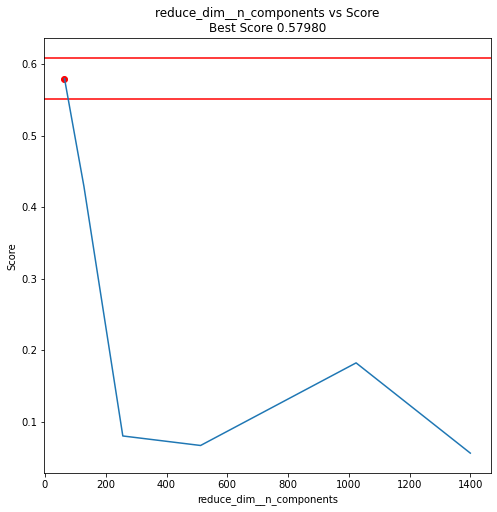

In [10]:
GridSearch_table_plot(grid, param_list=["reduce_dim__n_components"],negative=False)

In [11]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['QuadraticDiscriminantAnalysis']={"test":test_valutation}
print("Quadratic Discriminant Analysis")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")



{'reduce_dim': PCA(n_components=64), 'reduce_dim__n_components': 64}
Quadratic Discriminant Analysis
Accuracy: 0.6284658040665434
Macro f1: 0.5814342032815196
Confusion Matrix:
 [[109   4   3  17  18   6   2]
 [  7  13   0   3  11   7   5]
 [  7   1  19   4   1   8   4]
 [ 15   3   0  64   4   2   5]
 [  8   8   1   4  36   7   1]
 [  2   2   1   1   1  71   5]
 [  5   3   0   4   8   3  28]]


# K Neighbors Classifier

L'idea dietro kNN è la seguente: si considerano tutti gli elementi del training set e consideriamo i  elementi più vicini all'elemento che vogliamo classificare. 

La classificazione viene fatta assegnando il nuovo elemento alla classe che compare più frequentemente all'interno di questi  elementi.


In [13]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('KNeighborsClassifier', KNeighborsClassifier())])

parametri=  [
                {  
                    "reduce_dim": [PCA()],
                    "reduce_dim__n_components":[64,128,256,512,1024],
                    "KNeighborsClassifier__weights":['uniform', 'distance'],
                    "KNeighborsClassifier__n_neighbors":[1,3,5,10,20],
                    "KNeighborsClassifier__p":[0.5, 1,2,4,8,50,100]
                },
                {
                    "reduce_dim": ["passthrough"],
                    "KNeighborsClassifier__weights":['uniform', 'distance'],
                    "KNeighborsClassifier__n_neighbors":[1,3,5,10,20],
                    "KNeighborsClassifier__p":[0.5, 1,2,4,8,50,100]
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'KNeighborsClassifier__n_neighbors': 5, 'KNeighborsClassifier__p': 2, 'KNeighborsClassifier__weights': 'distance', 'reduce_dim': PCA(n_components=64), 'reduce_dim__n_components': 64}


C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 2100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\neighbors\_classification.py", line 198, in 

best parameters: {'KNeighborsClassifier__n_neighbors': 5, 'KNeighborsClassifier__p': 2, 'KNeighborsClassifier__weights': 'distance', 'reduce_dim': PCA(n_components=64), 'reduce_dim__n_components': 64}
best score:      0.54337 (+/-0.01276)


,param_KNeighborsClassifier__n_neighbors,param_KNeighborsClassifier__p,param_KNeighborsClassifier__weights,param_reduce_dim__n_components,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
165,5,2,distance,64,0.543371,0.012760,1,1.000000,0.000000
235,10,2,distance,64,0.535245,0.026345,2,1.000000,0.000000
245,10,4,distance,64,0.533702,0.031476,3,1.000000,0.000000
160,5,2,uniform,64,0.530069,0.020686,4,0.710679,0.009192
315,20,4,distance,64,0.526655,0.043943,5,1.000000,0.000000
240,10,4,uniform,64,0.525403,0.031789,6,0.658737,0.010221
175,5,4,distance,64,0.523360,0.038359,7,1.000000,0.000000
95,3,2,distance,64,0.519233,0.020184,8,1.000000,0.000000
255,10,8,distance,64,0.515309,0.032944,9,1.000000,0.000000
225,10,1,distance,64,0.514502,0.018368,10,1.000000,0.000000


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_KNeighborsClassifier__n_neighbors',
       'param_KNeighborsClassifier__p', 'param_KNeighborsClassifier__weights',
       'param_reduce_dim', 'param_reduce_dim__n_components', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


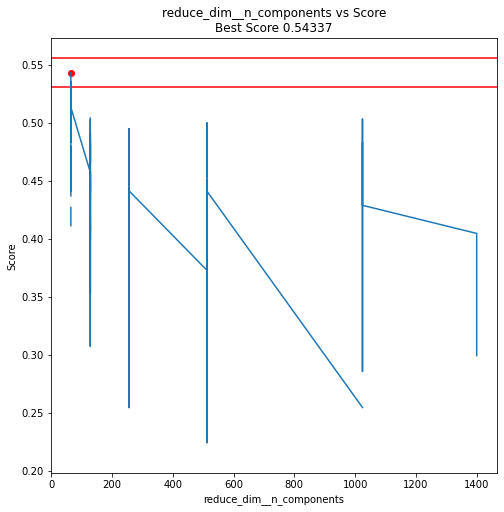

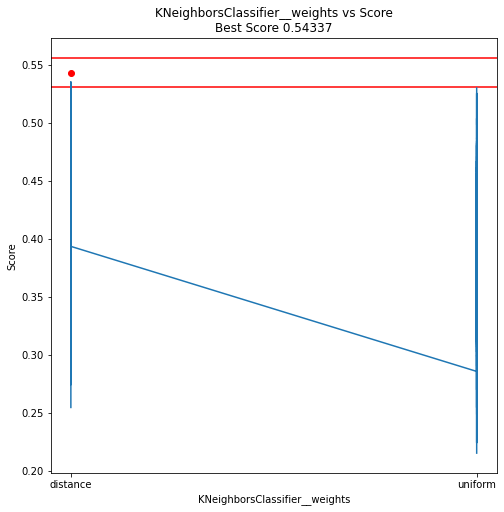

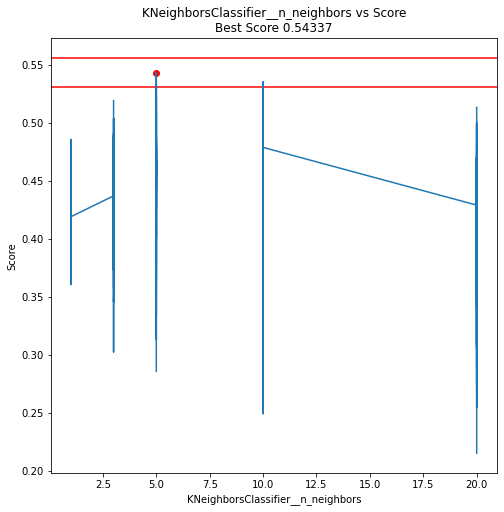

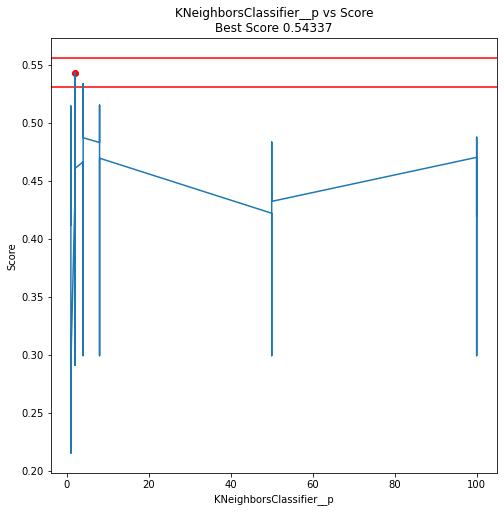

In [14]:
GridSearch_table_plot(grid, param_list=["reduce_dim__n_components","KNeighborsClassifier__weights","KNeighborsClassifier__n_neighbors","KNeighborsClassifier__p"],negative=False)

In [15]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['KNeighborsClassifier']={"test":test_valutation}
print("K-Neighbors Classifier")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")




{'KNeighborsClassifier__n_neighbors': 5, 'KNeighborsClassifier__p': 2, 'KNeighborsClassifier__weights': 'distance', 'reduce_dim': PCA(n_components=64), 'reduce_dim__n_components': 64}
K-Neighbors Classifier
Accuracy: 0.5785582255083179
Macro f1: 0.5482556941558568
Confusion Matrix:
 [[107   2   4  18  12  11   5]
 [ 19  12   1   3   6   4   1]
 [ 17   0  22   0   2   1   2]
 [ 24   0   1  58   3   2   5]
 [ 16   4   4   5  28   5   3]
 [ 11   1   2   4   3  61   1]
 [ 12   1   2   2   7   2  25]]


# Decision Tree Classifer

I decision Tree sono un metodo di apprendimento supervisionato non parametrico utilizzato per la classificazione e la regressione.
L'obiettivo è creare un modello che predice il valore di una variabile target apprendendo semplici regole decisionali dedotte dalle caratteristiche dei dati.

Gli alberi di decisione sono costruiti andando a partizionare in modo ricorsivo lo spazio delle features.

Supponiamo adesso di considerare un nodo e di volerlo partizionare.

L'idea è quella di andare a selezionare la feature e la soglia tali che una determinata misura è massimizzata nell'intersezione del training set con ognuna delle sottoregioni ottenute dalla partizione. Questa misura è una misura di impurità, e deve essere minimizzata.

la misura di impurità utilizzata in questo caso è il gini index

$G_S=1-\sum_{i=1}^k (\frac{|S_i|}{|S|} )^2$

dove $S$ è l'insieme del training set  $k$ è il numero di classi $S_i$ è l'insieme degli elementi della classe $i$

In [16]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('DecisionTreeClassifier', DecisionTreeClassifier())])

parametri=  [
                {  
                    "reduce_dim": [PCA()],
                    "reduce_dim__n_components":[64,128,256,512,1024],
                    "DecisionTreeClassifier__criterion":['gini','entropy'],
                    "DecisionTreeClassifier__max_depth":[4,8,16,32,64,128,256]

                },
                {
                    "reduce_dim": ["passthrough"],
                    "DecisionTreeClassifier__criterion":['gini','entropy'],
                    "DecisionTreeClassifier__max_depth":[4,8,16,32,64,128,256]
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'DecisionTreeClassifier__criterion': 'gini', 'DecisionTreeClassifier__max_depth': 64, 'reduce_dim': 'passthrough'}


best parameters: {'DecisionTreeClassifier__criterion': 'gini', 'DecisionTreeClassifier__max_depth': 64, 'reduce_dim': 'passthrough'}
best score:      0.60520 (+/-0.02085)


,param_DecisionTreeClassifier__criterion,param_DecisionTreeClassifier__max_depth,param_reduce_dim__n_components,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
74,gini,64,NaN,0.605202,0.020846,1,0.989291,0.002090
73,gini,32,NaN,0.603116,0.020598,2,0.915214,0.009551
80,entropy,32,NaN,0.600308,0.023168,3,0.948867,0.005524
75,gini,128,NaN,0.594920,0.022649,4,1.000000,0.000000
81,entropy,64,NaN,0.593944,0.032420,5,0.997954,0.001293
82,entropy,128,NaN,0.593453,0.024039,6,1.000000,0.000000
83,entropy,256,NaN,0.593255,0.027448,7,1.000000,0.000000
76,gini,256,NaN,0.591374,0.022957,8,1.000000,0.000000
72,gini,16,NaN,0.585910,0.021952,9,0.760070,0.006429
79,entropy,16,NaN,0.578417,0.021122,10,0.794439,0.007513


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_DecisionTreeClassifier__criterion',
       'param_DecisionTreeClassifier__max_depth', 'param_reduce_dim',
       'param_reduce_dim__n_components', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')


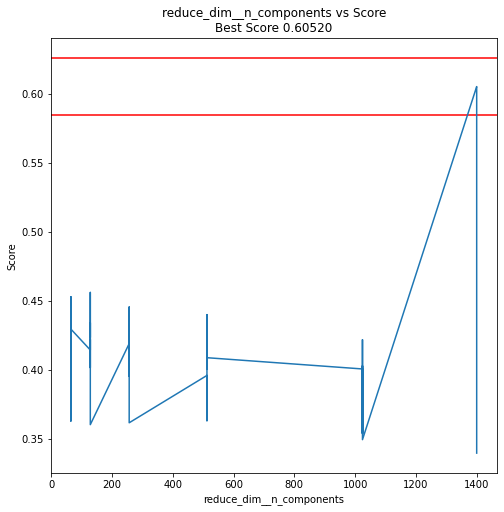

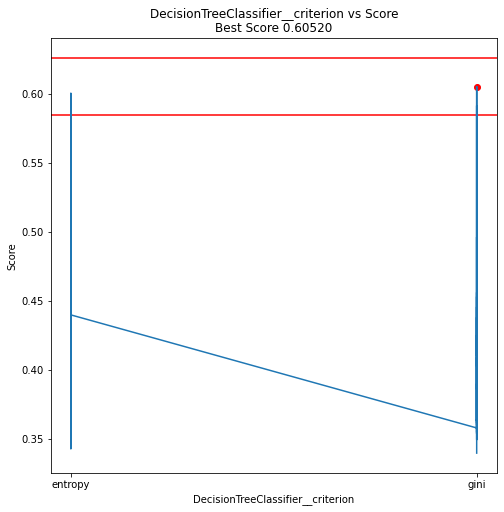

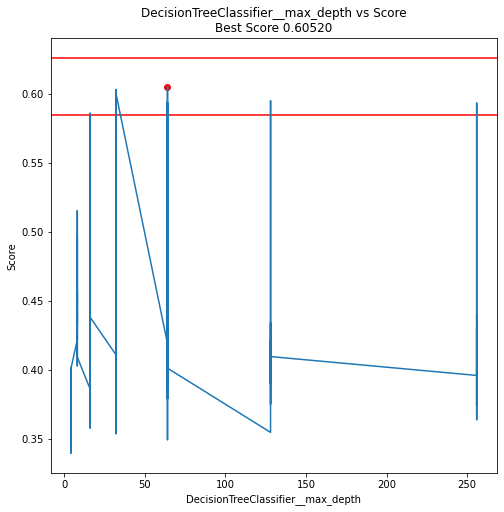

In [17]:
GridSearch_table_plot(grid, param_list=["reduce_dim__n_components","DecisionTreeClassifier__criterion","DecisionTreeClassifier__max_depth"],negative=False)

In [18]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
cros_valutation=valutate_model_with_kfold(model,dataset[0].x,dataset[0].y,n_splits=5)
dict_valutazioni['DecisionTreeClassifier']={"test":test_valutation,"kfold":cros_valutation}


print("DecisionTree Classifier")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print( f"kfold avg Accuracy: {cros_valutation['accuracy']}")
print( f"kfold avg Macro f1: {cros_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'DecisionTreeClassifier__criterion': 'gini', 'DecisionTreeClassifier__max_depth': 64, 'reduce_dim': 'passthrough'}
DecisionTree Classifier
Accuracy: 0.6432532347504621
Macro f1: 0.6222503661250313
kfold avg Accuracy: 0.646972600964457
kfold avg Macro f1: 0.6180821064859261
Confusion Matrix:
 [[116   0   6   9  17   5   6]
 [  7  23   0   3   5   4   4]
 [  2   3  25   5   3   3   3]
 [ 21   2   3  57   6   1   3]
 [ 14   3   2   4  36   3   3]
 [ 13   0   1   0   2  64   3]
 [ 10   2   1   2   7   2  27]]


# Random Forest Classifier

Random Forest è un meta stimatore che si adatta a un numero di alberi decisionali su vari sottocampioni del training set e utilizza la media o la maggioranza per migliorare l'accuratezza predittiva e controllare l'overfitting.

La creazione di una random forest di  alberi di decisione avviene nel seguente modo:

Per ogni albero $b= 1, ... ,B$
Si genera un sample dal training set.
Si apprende un albero di decisione  $T_b$ nel sample effettuando le seguenti operazioni per ogni nodo:

1. Si selezionano $m$ variabili (tra le features) in modo randomico
2. Si sceglie la "migliore" rispetto a queste  variabili
3. Si splitta il nodo in due figli
4. alla fine si ritorna la sequenza di alberi  $T_1, ... ,T_B$
Una volta che si ha la random forest nel caso della classificazione si procede calcolando la maggioranza

nel nostro caso abbiamo utilizzato una foresta di 100 alberi



In [19]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('RandomForestClassifier', RandomForestClassifier())])

parametri=  [
                {  
                    "reduce_dim": [PCA()],
                    "reduce_dim__n_components":[64,128,256,512,1024],
                    "RandomForestClassifier__criterion":['gini','entropy'],
                    "RandomForestClassifier__max_depth":[4,8,16,32,64,128,256],
                    "RandomForestClassifier__n_estimators":[64,128,256,512],


                },
                {
                    "reduce_dim": ["passthrough"],
                    "RandomForestClassifier__criterion":['gini','entropy'],
                    "RandomForestClassifier__max_depth":[4,8,16,32,64,128,256],
                    "RandomForestClassifier__n_estimators":[64,128,256,512],
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'RandomForestClassifier__criterion': 'gini', 'RandomForestClassifier__max_depth': 128, 'RandomForestClassifier__n_estimators': 128, 'reduce_dim': 'passthrough'}


best parameters: {'RandomForestClassifier__criterion': 'gini', 'RandomForestClassifier__max_depth': 128, 'RandomForestClassifier__n_estimators': 128, 'reduce_dim': 'passthrough'}
best score:      0.73153 (+/-0.02699)


,param_RandomForestClassifier__criterion,param_RandomForestClassifier__max_depth,param_RandomForestClassifier__n_estimators,param_reduce_dim__n_components,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
301,gini,128,128,NaN,0.731526,0.026995,1,1.000000,0.000000
307,gini,256,512,NaN,0.725329,0.023730,2,1.000000,0.000000
303,gini,128,512,NaN,0.724362,0.021571,3,1.000000,0.000000
306,gini,256,256,NaN,0.724163,0.021003,4,1.000000,0.000000
299,gini,64,512,NaN,0.723207,0.025248,5,0.991633,0.000683
297,gini,64,128,NaN,0.718849,0.029704,6,0.992523,0.000978
298,gini,64,256,NaN,0.718222,0.023974,7,0.992175,0.001632
302,gini,128,256,NaN,0.717731,0.018434,8,1.000000,0.000000
300,gini,128,64,NaN,0.717303,0.027326,9,1.000000,0.000000
305,gini,256,128,NaN,0.717085,0.025302,10,1.000000,0.000000


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_RandomForestClassifier__criterion',
       'param_RandomForestClassifier__max_depth',
       'param_RandomForestClassifier__n_estimators', 'param_reduce_dim',
       'param_reduce_dim__n_components', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')


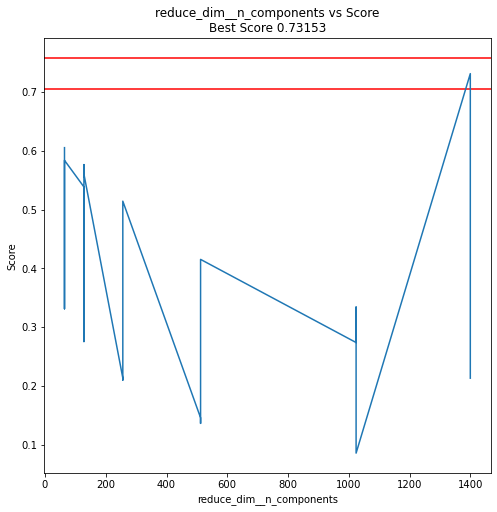

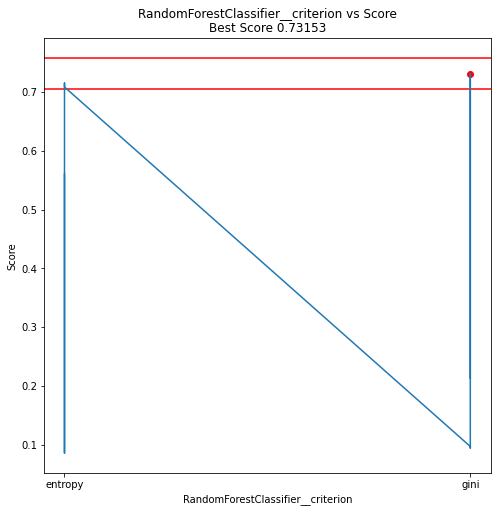

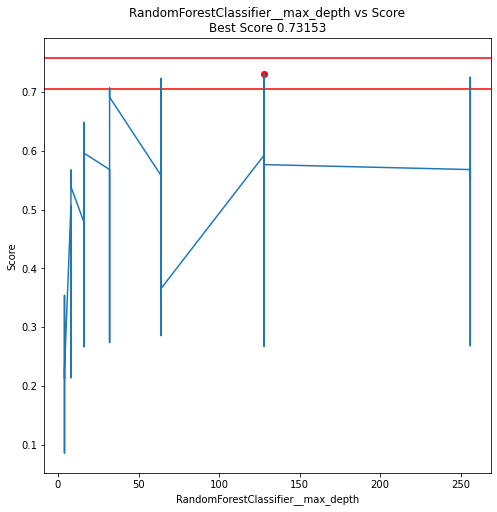

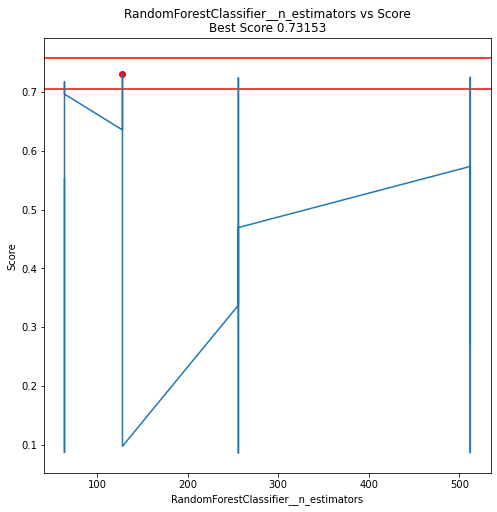

In [20]:
GridSearch_table_plot(grid, param_list=["reduce_dim__n_components","RandomForestClassifier__criterion","RandomForestClassifier__max_depth","RandomForestClassifier__n_estimators"],negative=False)

In [22]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['RandomForestClassifier']={"test":test_valutation,}
print("Random Forest Classifier")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'RandomForestClassifier__criterion': 'gini', 'RandomForestClassifier__max_depth': 128, 'RandomForestClassifier__n_estimators': 128, 'reduce_dim': 'passthrough'}
Random Forest Classifier
Accuracy: 0.7467652495378928
Macro f1: 0.7238997884703166
Confusion Matrix:
 [[137   2   0   7   9   3   1]
 [ 10  23   0   2   5   1   5]
 [  9   0  27   4   1   2   1]
 [ 12   1   1  69   3   2   5]
 [ 11   2   1   2  44   2   3]
 [ 10   0   2   0   1  68   2]
 [  5   0   1   1   7   1  36]]


# Support Vector Machines

Le support vector machines sono un modello di classificazione che ci permettono di definire degli iperpiani di separazione tra le classi.
L'idea di fondo delle SVMs infatti è quella di cercare l'iperpiano "migliore" che separa le classi nello spazio delle features rispetto ad una misura di separazione.

In [26]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('svm',svm.SVC())])

parametri=  [
                {  
                    "reduce_dim": [PCA()],
                    "reduce_dim__n_components":[64,128,256,512,1024],
                    "svm__kernel":['linear', 'poly', 'rbf', 'sigmoid'],
                    "svm__degree":[2,3,4,5,6,7],
                    "svm__decision_function_shape":['ovo', 'ovr'],
                    "svm__C": [0.1,0.5,1,10,50,100],
                    "svm__gamma": [0.001, 0.01 , 0.1 , 1 ,10, 100]


                },
                {
                    "reduce_dim": ["passthrough"],
                    "svm__kernel":['linear', 'poly', 'rbf', 'sigmoid'],
                    "svm__degree":[2,3,4,5,6,7],
                    "svm__decision_function_shape":['ovo', 'ovr'],
                    "svm__C": [0.1,0.5,1,10,50,100],
                    "svm__gamma": [0.001, 0.01 , 0.1 , 1 ,10, 100]
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

In [25]:
GridSearch_table_plot(grid, param_list=["reduce_dim__n_components","svm__kernel","svm__degree","svm__decision_function_shape","svm__gamma"],negative=False)

0.001
0.01
0.1
1.0
10.0
100.0


In [ ]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['svm']={"test":test_valutation}
print("SVM")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

## SVM kernel linear 

In [ ]:
model = svm.SVC(kernel='linear')
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
cros_valutation=valutate_model_with_kfold(model,dataset[0].x,dataset[0].y,n_splits=5)
dict_valutazioni['svmLinear']={"test":test_valutation,"kfold":cros_valutation}
print("SVM linear kernle")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print( f"kfold avg Accuracy: {cros_valutation['accuracy']}")
print( f"kfold avg Macro f1: {cros_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

SVM linear kernle
Accuracy: 0.7153419593345656
Macro f1: 0.6992698521717441
kfold avg Accuracy: 0.7322820252232098
kfold avg Macro f1: 0.7079583813466581
Confusion Matrix:
 [[123   3   1  10  14   4   4]
 [  7  26   2   1   5   0   5]
 [  6   0  31   3   2   2   0]
 [ 15   1   2  70   2   1   2]
 [  8   3   1   5  43   1   4]
 [  9   0   2   2   3  64   3]
 [  5   1   3   6   6   0  30]]


## SVM kernel poly

fromula polinomial kernel

$K\_poly(x,x')=(x^tx'+c)^d $

nel nostro caso il parametro d è 3

In [ ]:
model = svm.SVC(kernel='poly')
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
cros_valutation=valutate_model_with_kfold(model,dataset[0].x,dataset[0].y,n_splits=5)

dict_valutazioni['svmPoly']={"test":test_valutation,"kfold":cros_valutation}
print("SVM ploy kernel")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print( f"kfold avg Accuracy: {cros_valutation['accuracy']}")
print( f"kfold avg Macro f1: {cros_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

SVM ploy kernel
Accuracy: 0.4066543438077634
Macro f1: 0.2878444574845688
kfold avg Accuracy: 0.41655332819501945
kfold avg Macro f1: 0.2908421664093626
Confusion Matrix:
 [[159   0   0   0   0   0   0]
 [ 43   3   0   0   0   0   0]
 [ 40   0   3   0   0   1   0]
 [ 77   0   0  16   0   0   0]
 [ 55   0   0   1   9   0   0]
 [ 65   0   0   0   0  18   0]
 [ 38   0   0   0   1   0  12]]


## SVM kernel rbf

formula kernerl Radial basis function (rbf)

$K\_rbf(x,x')= exp(-\frac{|| x-x' ||^2}{2\sigma^2} ) $

In [ ]:
model = svm.SVC(kernel='rbf')
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
cros_valutation=valutate_model_with_kfold(model,dataset[0].x,dataset[0].y,n_splits=5)

dict_valutazioni['svmRbf']={"test":test_valutation,"kfold":cros_valutation}
print("SVM rbf  kernel")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print( f"kfold avg Accuracy: {cros_valutation['accuracy']}")
print( f"kfold avg Macro f1: {cros_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

SVM rbf kernel
Accuracy: 0.7264325323475046
Macro f1: 0.7028348926218905
kfold avg Accuracy: 0.7499942023449809
kfold avg Macro f1: 0.7279771936256241
Confusion Matrix:
 [[142   0   0   6  10   1   0]
 [ 14  18   0   0  11   0   3]
 [ 12   0  27   1   3   1   0]
 [ 21   0   0  70   1   0   1]
 [ 15   1   0   4  41   1   3]
 [ 12   0   1   0   2  67   1]
 [ 10   1   0   2   9   1  28]]


# Neural Networks

In [63]:

from keras.wrappers.scikit_learn import KerasClassifier

X_train=train_x.to('cpu').numpy()
Y_train=train_y.to('cpu').numpy()
X_test=test_x.to('cpu').numpy()
Y_test=test_y.to('cpu').numpy()

fulldataset_x=dataset[0].x.to('cpu').numpy()
fulldataset_y=dataset[0].y.to('cpu').numpy()

fulldataset_y= transform_to_one_hot(fulldataset_y)
Y_train = transform_to_one_hot(Y_train)
Y_test= transform_to_one_hot(Y_test)

def neural_model(num_layers,activation,num_node,dropout,optimizer):
    model = Sequential()
    model.add(Dense(num_node, input_dim=len(train_x[0]), activation=activation))
    model.add(Dropout(dropout))
    for x in range(num_layers):
        model.add(Dense(num_node*2, activation=activation))
        model.add(Dropout(dropout))
    
    model.add(Dense(7, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

#model=neural_model()
model = KerasClassifier(build_fn = neural_model, verbose=0)


pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('neuralNetwork',model)])
parametri=  [
                {  
                    "reduce_dim": [PCA()],
                    "reduce_dim__n_components":[64,128,256,512,1024],
                    "neuralNetwork__num_layers":[0,2,3,4,5],
                    "neuralNetwork__activation":["relu","sigmoid","tanh"],
                    "neuralNetwork__dropout":[0,0.1,0.2,0.3,0.5],
                    "neuralNetwork__optimizer":["adam","sgd","adadelta","adagrad"]

                },
                {
                    "reduce_dim": ["passthrough"],
                    "neuralNetwork__num_layers":[0,2,3,4,5],
                    "neuralNetwork__activation":["relu","sigmoid","tanh"],
                    "neuralNetwork__dropout":[0,0.1,0.2,0.3,0.5],
                    "neuralNetwork__optimizer":["adam","sgd","adadelta","adagrad"]
                }
            ]


grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

Epoch 1/50
68/68 [==============================] - 0s 971us/step - loss: 1.8607 - accuracy: 0.2612
Epoch 2/50
68/68 [==============================] - 0s 1ms/step - loss: 1.6935 - accuracy: 0.3401
Epoch 3/50
68/68 [==============================] - 0s 985us/step - loss: 1.4539 - accuracy: 0.4472
Epoch 4/50
68/68 [==============================] - 0s 1ms/step - loss: 1.1622 - accuracy: 0.5884
Epoch 5/50
68/68 [==============================] - 0s 1ms/step - loss: 0.9288 - accuracy: 0.6774
Epoch 6/50
68/68 [==============================] - 0s 1ms/step - loss: 0.7675 - accuracy: 0.7407
Epoch 7/50
68/68 [==============================] - 0s 1ms/step - loss: 0.6125 - accuracy: 0.7877
Epoch 8/50
68/68 [==============================] - 0s 1ms/step - loss: 0.4926 - accuracy: 0.8449
Epoch 9/50
68/68 [==============================] - 0s 1ms/step - loss: 0.3914 - accuracy: 0.8809
Epoch 10/50
68/68 [==============================] - 0s 1000us/step - loss: 0.3212 - accuracy: 0.8971
Epoch 11/50


In [64]:
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)
test_valutation=valutate_test(test_y,y_pred)
print("Neural Network")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")


Neural Network
Accuracy: 0.7486136783733827
Macro f1: 0.7311331193515102
Confusion Matrix:
 [[125   2   1   9  16   3   3]
 [  6  27   1   3   4   2   3]
 [  3   0  29   3   4   4   1]
 [ 12   1   2  69   3   1   5]
 [  3   2   1   4  50   1   4]
 [  7   1   2   1   0  70   2]
 [  4   1   1   3   6   1  35]]


In [59]:
kfold = KFold(n_splits=5, shuffle=True)
accuracy_list=[]
f1_list=[]
for train, test in kfold.split(fulldataset_x, fulldataset_y):
    model=neural_model()
    model.fit(fulldataset_x[train],fulldataset_y[train], epochs=50)
    y_pred = model.predict(fulldataset_x[test])
    y_pred=np.argmax(y_pred,axis=1)
    accuracy=metrics.accuracy_score(dataset[0].y[test], y_pred)
    f1=metrics.f1_score(dataset[0].y[test], y_pred,average='macro')
    accuracy_list.append(accuracy)
    f1_list.append(f1)
accuracy=sum(accuracy_list)/len(accuracy_list)
f1=sum(f1_list)/len(f1_list)
cros_valutation={"accuracy":accuracy,"f1":f1}

dict_valutazioni['Neural Network']={"test":test_valutation,"kfold":cros_valutation}

Epoch 1/50
68/68 [==============================] - 0s 850us/step - loss: 1.7700 - accuracy: 0.2950
Epoch 2/50
68/68 [==============================] - 0s 860us/step - loss: 1.1065 - accuracy: 0.6136
Epoch 3/50
68/68 [==============================] - 0s 859us/step - loss: 0.6136 - accuracy: 0.8139
Epoch 4/50
68/68 [==============================] - 0s 842us/step - loss: 0.3396 - accuracy: 0.9030
Epoch 5/50
68/68 [==============================] - 0s 907us/step - loss: 0.1959 - accuracy: 0.9451
Epoch 6/50
68/68 [==============================] - 0s 818us/step - loss: 0.1231 - accuracy: 0.9714
Epoch 7/50
68/68 [==============================] - 0s 853us/step - loss: 0.0833 - accuracy: 0.9825
Epoch 8/50
68/68 [==============================] - 0s 857us/step - loss: 0.0561 - accuracy: 0.9903
Epoch 9/50
68/68 [==============================] - 0s 834us/step - loss: 0.0507 - accuracy: 0.9903
Epoch 10/50
68/68 [==============================] - 0s 834us/step - loss: 0.0411 - accuracy: 0.9908

In [60]:

dict_valutazioni['Neural Network']={"test":test_valutation,"kfold":cros_valutation}

print("Neural Network")
print( f"kfold avg Accuracy: {cros_valutation['accuracy']}")
print( f"kfold avg Macro f1: {cros_valutation['f1']}")

Neural Network
kfold avg Accuracy: 0.7359645592759071
kfold avg Macro f1: 0.7072006691405194


# Graph neural network 


le graph neural network sono state progettate per lavorare su grafi, struttura che presenta le seguenti caratteristiche la rede inapplicabile con le tecniche di learning classiche:

1. Dimensione arbitraria e struttura topologica complessa
2. Ordine dei nodi non fissato
3. Nodi e archi con più feature

le graph neural network possono risolvere i task di classificazione di nodi di un grafo, di link prediction e possono essere utilizzate per avere una rappresentazione in uno spazio vettoriale dei nodi del grafo (dove la similarietà tra i nodi viene matentenuta).

## Contex diffusion 

1. **Inizializzazione**: gli stati iniziali dei nodi corrispondono al vettore delle feature o comunque sono in funzione di esso.

2. **message dispatching**: Un messaggio viene calcolato per ogni nodo usando il suo stato corrente e l’informazione dell’arco. Successivamente il messaggio viene inviato ai nodi vicini 

3. **state update**: i messaggi in arrivo da i vicini insieme al proprio stato corrente vengono usati per aggiornare lo stato del nodo

 
## Formulazione generale aggrecazione dei vicini

Aggregazione del vicinato per un nodo i al layer $l+1$

$x_i^{l+1} =   \phi^{l+1}(\Delta( \{ \delta^{l+1} (x_u^{l}) | u \in N_i \cup i  \}   ) ) $

1. $x_i^l$  è lo stato del nodo i al layer l 

2. $\phi , \delta  $  implementano trasformazioni dei dati di input (trasformazioni lineari i attraverso multi layare percentron)
3. $\Delta$ è la funzione di aggrecazione dei nodi vicini, in questo caso una funzione di aggreccazione valida deve essere permutation invariant inquanto  l'ordinamento dei nodi del vicinato non è definito. Alcuni esempi di funzioni di aggrecazione sono la somma o la media 
4. $N_i$ insieme dei vicini del nodo i 

 

In [9]:
#from torch_geometric.nn import GCNConv
#from torch_geometric.nn import GATConv
import torch.nn.functional as F

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch_geometric.nn as pyg_nn
import torch_geometric
import torch_geometric.utils as pyg_utils

## Implementazione del layer Graph Convolution Network 
    
Il layer GCN è cosi definito 
- $x_i^{(k)} = \sum \limits _{j \in N(i) \cup{i} } \frac{1} {\sqrt{deg(i)} \sqrt{deg(j)}}(\Theta^T x_j^{(k-1)} ) $

dove le caratteristiche dei nodi vicini vengono prima trasformate dala matrice dei pesi $\Theta$ , normalizzate per il loro grado e infine sommate. \
Questa formula può essere suddivisa nei seguenti passaggi:

1. Aggiungere gli archi a se stessi nella matrice di adiacenza 
2. Trasformare linearmente la matrice delle feature dei nodi $(\Theta^T x_j^{(k-1)} )$
3. Calcolare i coefficienti di normalizzazione $\frac{1} {\sqrt{deg(i)} \sqrt{deg(j)}}$
4. Normalizzare le feature dei nodi 
5. sommare le fature dei vicini ("add" aggregation)

adesso vediamo dove ognuno di questi passaggi viene eseguito nel codice

In [20]:


class MyGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Aggiungere gli archi a se stessi.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Trasformare linearmente la matrice delle feature dei nodi.
        x = self.lin(x)

        # Step 3: Calcolare la normalizzazione.
        i, j = edge_index
        deg = degree(j, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[i] * deg_inv_sqrt[j]

        # Step 4-5: Propagazione della feature del nodo ai vicini.
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4:normazia le feature dei nodi.
        return norm.view(-1, 1) * x_j

## Implementazione del modello

come vediamo dal codice abbiamo due layer di GCN itervallati dalla funzione di attivazione relu e un dropout,
l'ultimo l'ayer di GCN da in output un vettore di dimenione sette che viene passatto su una funzione di softmax prima di essere restituito
la loss utilizzata è la cross-entropy


In [6]:
class modello(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = MyGCNConv(dataset.num_node_features, 300)
        self.conv2 = MyGCNConv(300, dataset.num_classes)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        emb=x
        
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return emb,F.log_softmax(x, dim=1)
    
    def loss(self, pred, label):
        return F.nll_loss(pred, label)




def compute_accuracy_gnn(pred,label,total):
    pred=pred.argmax(dim=1)
    correct = (pred == label).sum()
    acc = int(correct) / total
    return acc

## Traning del modello
il training viene fatto su 50 epoche.
prima di farlo pero le embeddings del test set vengono azzerate per evitare che queste vengano usate durate il message passing all'interno del layer GCN  

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = modello().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
data.x[data.test_mask]= torch.zeros([1433], dtype=torch.float32).to(device)
model.train()
embeddings=[]
for epoch in range(50):
    #azzeramento del gradiente
    optimizer.zero_grad()
    
    emb,out = model(data)
    loss = model.loss( out[data.train_mask], data.y[data.train_mask])
    train_accuracy= compute_accuracy_gnn(out[data.train_mask], data.y[data.train_mask],int(data.train_mask.sum()))
    #test_accuracy = compute_accuracy_gnn(out[data.test_mask], data.y[data.test_mask],int(data.test_mask.sum()))
    print(f'epoch n\': {epoch} loss: {loss:.4f} train accuracy: {train_accuracy:.4f}' )
   # f'  test accuracy: {test_accuracy:.4f} ')
    #embeddings.append(emb)

    #calcolo del gradiente
    loss.backward()

    #aggiornamento dei parametri del modello 
    optimizer.step()
    


epoch n': 0 loss: 1.9372 train accuracy: 0.2340
epoch n': 1 loss: 1.7377 train accuracy: 0.3050
epoch n': 2 loss: 1.5200 train accuracy: 0.3092
epoch n': 3 loss: 1.2787 train accuracy: 0.5339
epoch n': 4 loss: 1.0270 train accuracy: 0.7674
epoch n': 5 loss: 0.8169 train accuracy: 0.8251
epoch n': 6 loss: 0.6327 train accuracy: 0.8648
epoch n': 7 loss: 0.4986 train accuracy: 0.8902
epoch n': 8 loss: 0.4048 train accuracy: 0.9008
epoch n': 9 loss: 0.3415 train accuracy: 0.9072
epoch n': 10 loss: 0.2968 train accuracy: 0.9068
epoch n': 11 loss: 0.2697 train accuracy: 0.9114
epoch n': 12 loss: 0.2393 train accuracy: 0.9211
epoch n': 13 loss: 0.2305 train accuracy: 0.9225
epoch n': 14 loss: 0.2152 train accuracy: 0.9275
epoch n': 15 loss: 0.1988 train accuracy: 0.9331
epoch n': 16 loss: 0.1884 train accuracy: 0.9349
epoch n': 17 loss: 0.1826 train accuracy: 0.9386
epoch n': 18 loss: 0.1743 train accuracy: 0.9400
epoch n': 19 loss: 0.1660 train accuracy: 0.9386
epoch n': 20 loss: 0.1639 trai

In [26]:
model.eval()
emb,pred = model(data)
pred=pred.argmax(dim=1)
test=valutate_test(pred[data.test_mask].cpu(),test_y.cpu())
print(f"Accuracy test set: {test['Accuracy']}, f1 test set: {test['f1']}")
print(test['Confusion Matrix'])
dict_valutazioni['GCN']={"test":test,"kfold":{}}


Accuracy test set: 0.8743068391866913, f1 test set: 0.8632751520333913
[[138   4   1   2   7   3   5]
 [  0  35   0   0   0   0   2]
 [  3   0  38   1   1   0   0]
 [  5   0   1  89   1   0   2]
 [  6   4   1   1  56   0   4]
 [  0   0   2   0   0  80   1]
 [  7   3   1   0   0   0  37]]


### Training con Kfold

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


data = dataset[0].to(device)

embeddings=[]

kfold = KFold(n_splits=5, shuffle=True)

accuracy_list=[]
f1_list=[]
for train, test in kfold.split(data.x, data.y):
    
    model = modello().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.train()
    
    data_clone=data.clone()
    data_clone.x[test]=torch.zeros([1433], dtype=torch.float32).to(device)
    for epoch in range(50):
        optimizer.zero_grad()
        emb,out = model(data_clone)
        train_accuracy= compute_accuracy_gnn(out[train], data_clone.y[train],len(train))
        
        print(f'epoch n\': {epoch} loss: {loss:.4f} train accuracy: {train_accuracy:.4f}' )
        loss = model.loss( out[train], data_clone.y[train])

        loss.backward()
        optimizer.step()
    model.eval()
    emb,pred = model(data_clone)
    pred=pred.argmax(dim=1)
    test=valutate_test(pred[test].cpu(),data_clone.y[test].cpu())
    print(f"Accuracy test set: {test['Accuracy']}, f1 test set: {test['f1']}")
    accuracy_list.append(test['Accuracy'])
    f1_list.append(test['f1'])
accuracy=sum(accuracy_list)/len(accuracy_list)
f1=sum(f1_list)/len(f1_list)
dict_valutazioni['GCN']["kfold"]={'accuracy':accuracy, 'f1':f1}




epoch n': 0 loss: 0.1185 train accuracy: 0.1976
epoch n': 1 loss: 1.9394 train accuracy: 0.3029
epoch n': 2 loss: 1.7395 train accuracy: 0.3116
epoch n': 3 loss: 1.5333 train accuracy: 0.5512
epoch n': 4 loss: 1.2907 train accuracy: 0.7641
epoch n': 5 loss: 1.0477 train accuracy: 0.8352
epoch n': 6 loss: 0.8322 train accuracy: 0.8693
epoch n': 7 loss: 0.6471 train accuracy: 0.8980
epoch n': 8 loss: 0.5044 train accuracy: 0.9012
epoch n': 9 loss: 0.4097 train accuracy: 0.9049
epoch n': 10 loss: 0.3464 train accuracy: 0.9160
epoch n': 11 loss: 0.3014 train accuracy: 0.9192
epoch n': 12 loss: 0.2687 train accuracy: 0.9192
epoch n': 13 loss: 0.2518 train accuracy: 0.9266
epoch n': 14 loss: 0.2378 train accuracy: 0.9280
epoch n': 15 loss: 0.2248 train accuracy: 0.9340
epoch n': 16 loss: 0.2076 train accuracy: 0.9331
epoch n': 17 loss: 0.1918 train accuracy: 0.9372
epoch n': 18 loss: 0.1922 train accuracy: 0.9367
epoch n': 19 loss: 0.1799 train accuracy: 0.9381
epoch n': 20 loss: 0.1721 trai

In [ ]:
print(f"average accuracy gnn kfold: {accuracy}")
print(f"average f1 gnn kfold: {f1}")


average accuracy gnn kfold: 0.8707566280838408
average f1 gnn kfold: 0.8637847134125961


## Visualizzazioni delle embeddings calcolate

### Plot delle embeddings nel traning set

C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


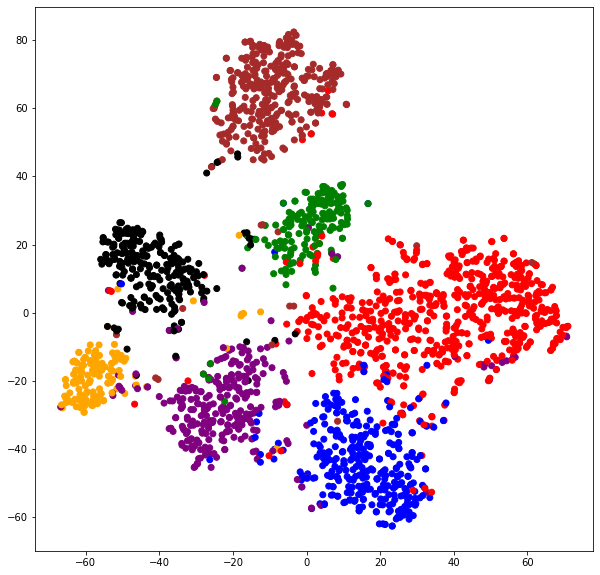

In [28]:
xs, ys = compute_TSNE(emb.cpu())

plot_embeddings(xs[data.train_mask],ys[data.train_mask],data.y[data.train_mask].cpu())

### Plot delle embeddings nel test set

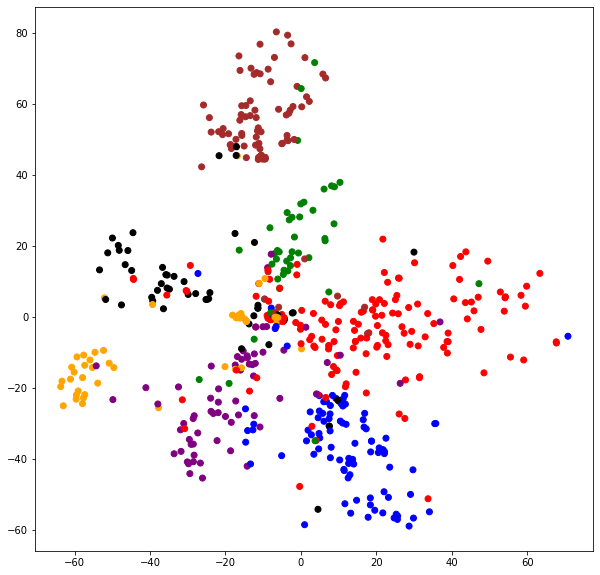

In [29]:
plot_embeddings(xs[data.test_mask],ys[data.test_mask],data.y[data.test_mask].cpu())

### Plot delle embeddings calcolate in ogni epoca

In [ ]:
#plot delle embeddings per ogni epoca
def plot_all_epoch_embeddings(): 
    color_list = ["red", "orange", "green", "blue", "purple", "brown","black","gray","yellow"]
    i=0
    for emb in embeddings:
        embs = []
        colors = []
        embs.append(emb.cpu())
        yl=data.y
        colors += [color_list[y] for y in yl]
        embs = torch.cat(embs, dim=0)
        xs, ys = zip(*TSNE(init='pca',random_state=33).fit_transform(embs.detach().numpy()))
        plt.scatter(xs, ys, color=colors)
        plt.savefig(f'./embeddings_scatter/epoch{i}.png')
        plt.close()
        i=i+1

from IPython.display import Image, display
for x in range(0,10):
    display(Image( f'./embeddings_scatter/epoch{x}.png'))


# Graph auto encoders 
Con i grpah auto encoder possiamo apprendere le rappresentazioni dei nodi in modo non supervisionato (usiamo esclusivamente gli archi).
Contrariamente all'esempio precedente, non utilizziamo le labels dei nodi fornite durante l'addestramento. Invece, codifichiamo i nodi del grafo  in modo tale che le embedding dei nodi possono essere decodificate come ricostrizione del grafo originale. 
Usiamo usimo lo stesso layer del metodo precedente.

In [36]:


dataset=MyDatasetLoader(root='./cora')
data=dataset[0]


class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = MyGCNConv(in_channels,  out_channels*2)
        self.conv2 = MyGCNConv(out_channels*2, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)




dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
channels = 30
model = pyg_nn.GAE(Encoder(dataset.num_features, channels)).to(dev)
labels = data.y
data.train_mask = data.val_mask = data.test_mask = data.y = None
#il metodo train_test_split_edges()
#divide gli archi del grafo in positivi e nagativi nei rispettivi train/val/test. 
randomSplit_links =  pyg_utils.train_test_split_edges(data)


Processing...
Done!
C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


## Training  Graph auto encoders 

in traing è simile al precedente ma cambia la funzione di loss recon_loss() che calcola
la binary cross entropy loss per gli archi positivi e nagetivi estratti mediante sampling (gli archi negativi a.k.a inesitenti vengono estratti allinterno di recon_loss(),  comunque possibile passaglierli in input) 

In [37]:
def accuracy_f1_confusion_link_prediction(model,X, pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(X, train_pos_edge_index)
        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)
        pos_pred = model.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = model.decoder(z, neg_edge_index, sigmoid=True)
        #print(len(pos_pred))
        #print(len(neg_pred))
        pred = torch.cat([pos_pred, neg_pred], dim=0)
        pred = torch.as_tensor((pred - 0.70) > 0, dtype=torch.int32) 

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()
        
        acc=metrics.accuracy_score(y, pred)
        f=metrics.f1_score(y, pred)
        confmatr=metrics.confusion_matrix(y, pred)
        return acc,f,confmatr

In [38]:



x, train_pos_edge_index = randomSplit_links.x.to(dev), randomSplit_links.train_pos_edge_index.to(dev)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
for epoch in range(1, 100):
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    accuracy, f1, conf = accuracy_f1_confusion_link_prediction(model,x,data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, accuracy: {:.4f}, f1: {:.4f}'.format(epoch, accuracy, f1))
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()








def test(X,pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(X, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)


Epoch: 001, accuracy: 0.5185, f1: 0.0712
Epoch: 002, accuracy: 0.6402, f1: 0.6493
Epoch: 003, accuracy: 0.5221, f1: 0.0848
Epoch: 004, accuracy: 0.5037, f1: 0.0147
Epoch: 005, accuracy: 0.5268, f1: 0.1016
Epoch: 006, accuracy: 0.5489, f1: 0.1917
Epoch: 007, accuracy: 0.5461, f1: 0.1745
Epoch: 008, accuracy: 0.5461, f1: 0.1773
Epoch: 009, accuracy: 0.5554, f1: 0.2124
Epoch: 010, accuracy: 0.5738, f1: 0.2870
Epoch: 011, accuracy: 0.6107, f1: 0.4106
Epoch: 012, accuracy: 0.6448, f1: 0.5311
Epoch: 013, accuracy: 0.6642, f1: 0.5973
Epoch: 014, accuracy: 0.6744, f1: 0.6272
Epoch: 015, accuracy: 0.6946, f1: 0.6577
Epoch: 016, accuracy: 0.7288, f1: 0.6963
Epoch: 017, accuracy: 0.7343, f1: 0.6994
Epoch: 018, accuracy: 0.7306, f1: 0.6965
Epoch: 019, accuracy: 0.7518, f1: 0.7230
Epoch: 020, accuracy: 0.7509, f1: 0.7273
Epoch: 021, accuracy: 0.7500, f1: 0.7293
Epoch: 022, accuracy: 0.7528, f1: 0.7357
Epoch: 023, accuracy: 0.7491, f1: 0.7349
Epoch: 024, accuracy: 0.7445, f1: 0.7298
Epoch: 025, accu

In [39]:


accuracy,f1,confmatr=accuracy_f1_confusion_link_prediction(model,x,data.test_pos_edge_index, data.test_neg_edge_index)
print(f"link prediction:\nAccuracy: {accuracy:.4f}\nF1 score {f1:.4f}\n confusion matrix:\n {confmatr}")

link prediction:
Accuracy: 0.8349
F1 score 0.8287
 confusion matrix:
 [[472  70]
 [109 433]]


## Plot delle embedding ricalcolate con GAE

C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


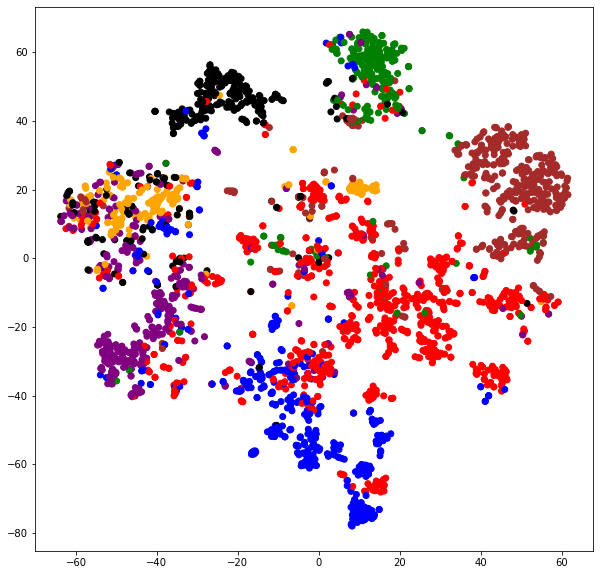

In [40]:
model.eval()
embeddings_auto_encoders = model.encode(x, train_pos_edge_index)
xs,ys=compute_TSNE(embeddings_auto_encoders.cpu())
plot_embeddings(xs,ys,labels.cpu())

# Sommario prestazioni vari modelli 

## Prestazioni sul Test Set

(0.0, 1.0, 0.0, 1.0)

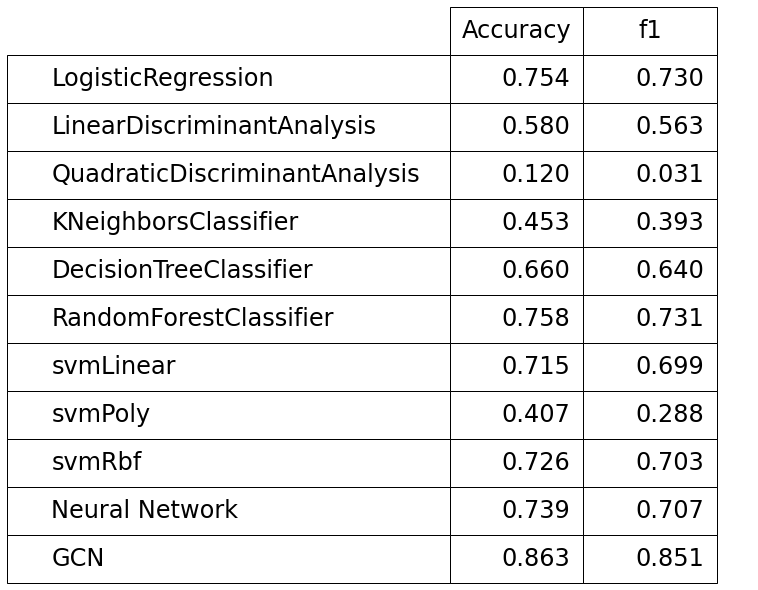

In [ ]:
dict_valutazioni.keys()
rows= list(dict_valutazioni.keys())
columns=['Accuracy',"f1"]
table_vars=[]

for x in rows:
    row=[]
    row.append(f"{dict_valutazioni[x]['test']['Accuracy']:.3f}")
    row.append(f"{dict_valutazioni[x]['test']['f1']:.3f}")
    table_vars.append(row)
    

the_table = plt.table(cellText=table_vars,
                      colWidths=[0.1] * 3,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(4, 4)
plt.axis('off')



## Prestazioni su kFold (medie)

(0.0, 1.0, 0.0, 1.0)

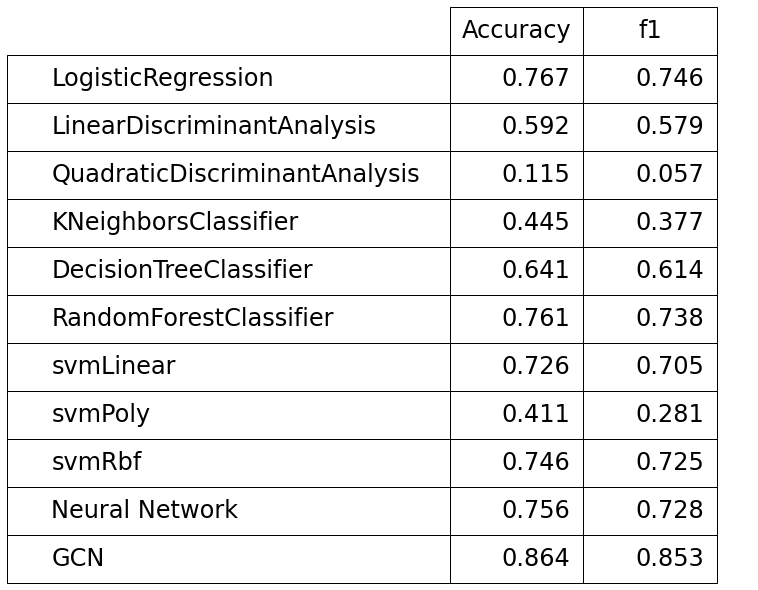

In [ ]:
dict_valutazioni.keys()
rows= list(dict_valutazioni.keys())
columns=['Accuracy',"f1"]
table_vars=[]

for x in rows:
    row=[]  
    row.append(f"{dict_valutazioni[x]['kfold']['accuracy']:.3f}")
    row.append(f"{dict_valutazioni[x]['kfold']['f1']:.3f}")
    table_vars.append(row)
    
the_table = plt.table(cellText=table_vars,
                      colWidths=[0.1] * 3,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(4, 4)
plt.axis('off')


# Prova dei vai modelli con le con con embddings ricalcolate

In [ ]:
#eseguire questa cella per usare le embedding calcolate con GCN neli modelli successivi

train_x=emb[data.train_mask].cpu().detach().numpy()
train_y=data.y[data.train_mask].cpu().detach().numpy()
test_x=emb[data.test_mask].cpu().detach().numpy()
test_y=data.y[data.test_mask].cpu().detach().numpy()
dict_valutazioni={}

In [ ]:
#eseguire questa cella per usare le embedding calcolate con GAE nei modelli successivi
data=dataset[0]
train_x=embeddings_auto_encoders[data.train_mask].cpu().detach().numpy()
train_y=data.y[data.train_mask].cpu().detach().numpy()
test_x=embeddings_auto_encoders[data.test_mask].cpu().detach().numpy()
test_y=data.y[data.test_mask].cpu().detach().numpy()
dict_valutazioni={}

## Logistic regression 

In [ ]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=1.0)
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
print("valutazione con test 20%",test_valutation)
print(test_valutation["Confusion Matrix"])
dict_valutazioni['LogisticRegression']={"test":test_valutation}

valutazione con test 20% {'Accuracy': 0.7486136783733827, 'f1': 0.7340766495224104, 'Confusion Matrix': array([[120,   3,   1,  10,  14,   3,   8],
       [  7,  22,   0,   6,   7,   0,   4],
       [  1,   0,  38,   0,   0,   4,   1],
       [  8,   3,   2,  75,   4,   0,   1],
       [  6,   4,   0,   2,  49,   0,   4],
       [ 11,   1,   1,   0,   0,  68,   2],
       [  4,   1,   0,   4,   7,   2,  33]], dtype=int64)}
[[120   3   1  10  14   3   8]
 [  7  22   0   6   7   0   4]
 [  1   0  38   0   0   4   1]
 [  8   3   2  75   4   0   1]
 [  6   4   0   2  49   0   4]
 [ 11   1   1   0   0  68   2]
 [  4   1   0   4   7   2  33]]


## Linear Discriminant Analysis

In [ ]:
model = LinearDiscriminantAnalysis(store_covariance=True)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
print("valutazione con test 20%",test_valutation)
print(test_valutation["Confusion Matrix"])
dict_valutazioni['LinearDiscriminantAnalysis']={"test":test_valutation}

valutazione con test 20% {'Accuracy': 0.7375231053604436, 'f1': 0.7312601174823058, 'Confusion Matrix': array([[107,  12,   1,  17,  16,   0,   6],
       [  5,  26,   0,   6,   4,   0,   5],
       [  1,   0,  39,   0,   0,   4,   0],
       [  5,   3,   2,  76,   5,   0,   2],
       [  4,   5,   0,   2,  51,   0,   3],
       [ 10,   1,   1,   1,   0,  67,   3],
       [  4,   3,   1,   1,   8,   1,  33]], dtype=int64)}
[[107  12   1  17  16   0   6]
 [  5  26   0   6   4   0   5]
 [  1   0  39   0   0   4   0]
 [  5   3   2  76   5   0   2]
 [  4   5   0   2  51   0   3]
 [ 10   1   1   1   0  67   3]
 [  4   3   1   1   8   1  33]]


## Quadratic Discriminant Analysis

In [ ]:
model = QuadraticDiscriminantAnalysis(store_covariance=True)
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
print("valutazione con test 20%",test_valutation)
print(test_valutation["Confusion Matrix"])
dict_valutazioni['QuadraticDiscriminantAnalysis']={"test":test_valutation}

valutazione con test 20% {'Accuracy': 0.5748613678373382, 'f1': 0.5943468379678093, 'Confusion Matrix': array([[12,  6,  6, 24, 54, 45, 12],
       [ 0, 28,  0,  1,  4,  4,  9],
       [ 0,  0, 36,  0,  1,  6,  1],
       [ 1,  2,  1, 66, 14,  5,  4],
       [ 0,  4,  0,  1, 51,  2,  7],
       [ 1,  0,  1,  0,  2, 77,  2],
       [ 0,  1,  0,  1,  4,  4, 41]], dtype=int64)}
[[12  6  6 24 54 45 12]
 [ 0 28  0  1  4  4  9]
 [ 0  0 36  0  1  6  1]
 [ 1  2  1 66 14  5  4]
 [ 0  4  0  1 51  2  7]
 [ 1  0  1  0  2 77  2]
 [ 0  1  0  1  4  4 41]]


C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## K Neighbors Classifier

In [ ]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
print("valutazione con test 20%",test_valutation)
print(test_valutation["Confusion Matrix"])
dict_valutazioni['KNeighborsClassifier']={"test":test_valutation}

valutazione con test 20% {'Accuracy': 0.8354898336414048, 'f1': 0.8282757439640328, 'Confusion Matrix': array([[131,   3,   3,   3,  12,   1,   6],
       [  3,  39,   0,   1,   2,   0,   1],
       [  1,   0,  40,   0,   0,   2,   1],
       [  9,   0,   1,  81,   2,   0,   0],
       [  7,   5,   0,   1,  50,   0,   2],
       [  4,   1,   1,   0,   0,  76,   1],
       [  3,   4,   1,   5,   3,   0,  35]], dtype=int64)}
[[131   3   3   3  12   1   6]
 [  3  39   0   1   2   0   1]
 [  1   0  40   0   0   2   1]
 [  9   0   1  81   2   0   0]
 [  7   5   0   1  50   0   2]
 [  4   1   1   0   0  76   1]
 [  3   4   1   5   3   0  35]]


## Decision Tree Classifer

In [ ]:
model = DecisionTreeClassifier()
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
print("valutazione con test 20%",test_valutation)
print(test_valutation["Confusion Matrix"])
dict_valutazioni['DecisionTreeClassifier']={"test":test_valutation}

valutazione con test 20% {'Accuracy': 0.7264325323475046, 'f1': 0.7113115359262253, 'Confusion Matrix': array([[118,   3,   2,  12,  14,   4,   6],
       [  5,  31,   1,   1,   4,   0,   4],
       [  1,   0,  30,   1,   3,   5,   4],
       [ 12,   3,   1,  72,   4,   0,   1],
       [  8,   4,   0,   1,  43,   2,   7],
       [  9,   1,   4,   0,   0,  68,   1],
       [  5,   3,   0,   6,   4,   2,  31]], dtype=int64)}
[[118   3   2  12  14   4   6]
 [  5  31   1   1   4   0   4]
 [  1   0  30   1   3   5   4]
 [ 12   3   1  72   4   0   1]
 [  8   4   0   1  43   2   7]
 [  9   1   4   0   0  68   1]
 [  5   3   0   6   4   2  31]]


## Random Forest Classifier

In [ ]:
model=RandomForestClassifier(n_estimators=100)
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
print("valutazione con test 20%",test_valutation)
print(test_valutation["Confusion Matrix"])
dict_valutazioni['RandomForestClassifier']={"test":test_valutation}

valutazione con test 20% {'Accuracy': 0.8373382624768947, 'f1': 0.8310959615221709, 'Confusion Matrix': array([[137,   1,   1,   5,  12,   0,   3],
       [  3,  35,   0,   2,   5,   0,   1],
       [  0,   0,  40,   0,   0,   3,   1],
       [  4,   0,   2,  82,   4,   0,   1],
       [  6,   3,   0,   1,  49,   0,   6],
       [ 10,   0,   0,   0,   0,  72,   1],
       [  3,   1,   0,   3,   6,   0,  38]], dtype=int64)}
[[137   1   1   5  12   0   3]
 [  3  35   0   2   5   0   1]
 [  0   0  40   0   0   3   1]
 [  4   0   2  82   4   0   1]
 [  6   3   0   1  49   0   6]
 [ 10   0   0   0   0  72   1]
 [  3   1   0   3   6   0  38]]


## Support Vector Machines

### SVM kernel linear

In [ ]:
model = svm.SVC(kernel='linear')
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
print("valutazione con test 20%",test_valutation)
print(test_valutation["Confusion Matrix"])
dict_valutazioni['svmLinear']={"test":test_valutation}

valutazione con test 20% {'Accuracy': 0.7800369685767098, 'f1': 0.7666488339602263, 'Confusion Matrix': array([[128,   4,   1,  10,  10,   1,   5],
       [  7,  28,   0,   3,   5,   0,   3],
       [  1,   0,  37,   0,   0,   5,   1],
       [  8,   3,   2,  76,   3,   0,   1],
       [  6,   5,   0,   1,  51,   0,   2],
       [ 10,   1,   0,   0,   0,  71,   1],
       [  5,   2,   0,   4,   9,   0,  31]], dtype=int64)}
[[128   4   1  10  10   1   5]
 [  7  28   0   3   5   0   3]
 [  1   0  37   0   0   5   1]
 [  8   3   2  76   3   0   1]
 [  6   5   0   1  51   0   2]
 [ 10   1   0   0   0  71   1]
 [  5   2   0   4   9   0  31]]


### SVM kernel poly

In [ ]:
model = svm.SVC(kernel='poly')
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
print("valutazione con test 20%",test_valutation)
print(test_valutation["Confusion Matrix"])
dict_valutazioni['svmPoly']={"test":test_valutation}

valutazione con test 20% {'Accuracy': 0.7707948243992606, 'f1': 0.7646643368939766, 'Confusion Matrix': array([[141,   1,   1,   4,   8,   0,   4],
       [ 12,  27,   0,   1,   3,   0,   3],
       [  4,   0,  36,   0,   0,   4,   0],
       [ 18,   0,   2,  72,   1,   0,   0],
       [ 14,   3,   0,   0,  44,   0,   4],
       [ 14,   0,   0,   0,   0,  68,   1],
       [ 14,   1,   0,   1,   6,   0,  29]], dtype=int64)}
[[141   1   1   4   8   0   4]
 [ 12  27   0   1   3   0   3]
 [  4   0  36   0   0   4   0]
 [ 18   0   2  72   1   0   0]
 [ 14   3   0   0  44   0   4]
 [ 14   0   0   0   0  68   1]
 [ 14   1   0   1   6   0  29]]


### SVM kernel rbf

In [ ]:
model = svm.SVC(kernel='rbf')
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
print("valutazione con test 20%",test_valutation)
print(test_valutation["Confusion Matrix"])
dict_valutazioni['svmRbf']={"test":test_valutation}

valutazione con test 20% {'Accuracy': 0.8170055452865065, 'f1': 0.8031548849252823, 'Confusion Matrix': array([[135,   5,   0,   6,  10,   0,   3],
       [  5,  33,   0,   2,   4,   0,   2],
       [  1,   0,  36,   0,   0,   5,   2],
       [  7,   0,   2,  80,   3,   0,   1],
       [  4,   4,   0,   2,  52,   0,   3],
       [  8,   0,   0,   1,   0,  73,   1],
       [  3,   2,   0,   4,   8,   1,  33]], dtype=int64)}
[[135   5   0   6  10   0   3]
 [  5  33   0   2   4   0   2]
 [  1   0  36   0   0   5   2]
 [  7   0   2  80   3   0   1]
 [  4   4   0   2  52   0   3]
 [  8   0   0   1   0  73   1]
 [  3   2   0   4   8   1  33]]


## neural networks

In [ ]:
Y_train = transform_to_one_hot(train_y)
Y_test= transform_to_one_hot(test_y)
def neural_model():
    model = Sequential()
    model.add(Dense(50, input_dim=len(train_x[0]), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model=neural_model()
model.fit(train_x, Y_train, epochs=20)


Epoch 1/20
68/68 [==============================] - 0s 691us/step - loss: 1.7887 - accuracy: 0.3036
Epoch 2/20
68/68 [==============================] - 0s 691us/step - loss: 1.4778 - accuracy: 0.4485
Epoch 3/20
68/68 [==============================] - 0s 721us/step - loss: 1.2015 - accuracy: 0.5976
Epoch 4/20
68/68 [==============================] - 0s 691us/step - loss: 1.0908 - accuracy: 0.6465
Epoch 5/20
68/68 [==============================] - 0s 691us/step - loss: 0.9943 - accuracy: 0.6737
Epoch 6/20
68/68 [==============================] - 0s 676us/step - loss: 0.9713 - accuracy: 0.6802
Epoch 7/20
68/68 [==============================] - 0s 676us/step - loss: 0.9260 - accuracy: 0.7014
Epoch 8/20
68/68 [==============================] - 0s 706us/step - loss: 0.9140 - accuracy: 0.7065
Epoch 9/20
68/68 [==============================] - 0s 706us/step - loss: 0.8874 - accuracy: 0.7254
Epoch 10/20
68/68 [==============================] - 0s 721us/step - loss: 0.8701 - accuracy: 0.7130

In [ ]:
y_pred = model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)
test_valutation=valutate_test(test_y,y_pred)
print(test_valutation)
dict_valutazioni['Neural Network']={"test":test_valutation}

{'Accuracy': 0.7707948243992606, 'f1': 0.7573326176448435, 'Confusion Matrix': array([[118,   8,   1,  13,  11,   2,   6],
       [  3,  27,   0,   7,   6,   0,   3],
       [  1,   0,  37,   0,   0,   5,   1],
       [  5,   1,   2,  81,   3,   0,   1],
       [  6,   7,   0,   1,  46,   0,   5],
       [  8,   1,   0,   0,   0,  72,   2],
       [  1,   2,   0,   4,   6,   2,  36]], dtype=int64)}


## Risultati con embedding ricalcolate 

(0.0, 1.0, 0.0, 1.0)

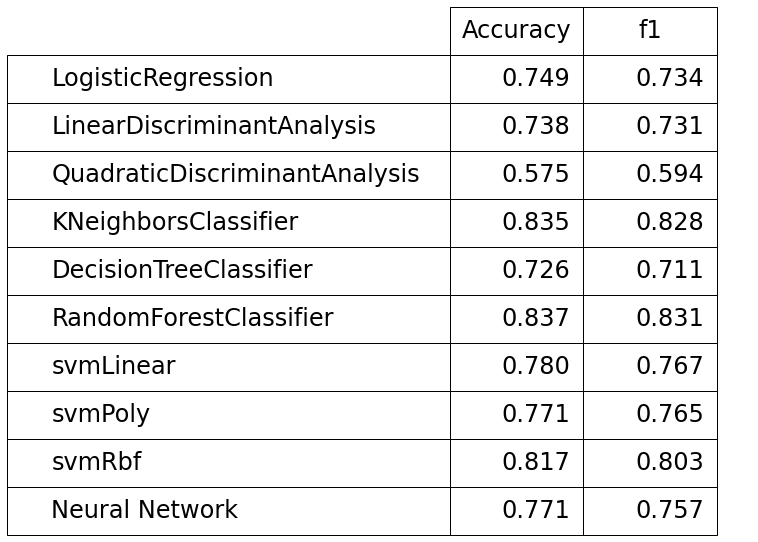

In [ ]:
dict_valutazioni.keys()
rows= list(dict_valutazioni.keys())
columns=['Accuracy',"f1"]
table_vars=[]

for x in rows:
    row=[]  
    row.append(f"{dict_valutazioni[x]['test']['Accuracy']:.3f}")
    row.append(f"{dict_valutazioni[x]['test']['f1']:.3f}")
    table_vars.append(row)
    
the_table = plt.table(cellText=table_vars,
                      colWidths=[0.1] * 3,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(4, 4)
plt.axis('off')

# Risultati a confronto

![title](https://raw.githubusercontent.com/naddi96/progetto-ML/master/benchmark.png)